# CSE 283 Project

In [407]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [159]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve, auc, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# C1-C28: recurrence samples; C29-C96: non-recurrence samples
df = pd.read_csv("GSE131512_cancerTPM.txt.gz", sep='\t')
print(df.shape)
df.head()

(60675, 96)


,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96
ENSG00000000003,7.071605,60.610797,58.255903,29.917356,24.500322,25.311091,37.394452,15.354658,24.839014,24.591295,...,14.134044,10.803910,6.068982,12.714350,15.983392,0.000000,38.189128,15.608352,51.519267,30.805593
ENSG00000000005,13.279391,47.424080,60.455497,6.482332,53.675826,31.686900,32.409716,0.000000,48.976056,46.178684,...,0.000000,12.172853,136.759411,28.650721,0.000000,0.000000,5.976111,6.280734,241.863225,0.000000
ENSG00000000419,0.000000,0.000000,23.040206,8.646690,20.456404,42.266702,21.615428,11.538256,18.665274,76.996356,...,79.657691,8.118597,0.000000,0.000000,0.000000,179.178412,15.942897,0.000000,0.000000,0.000000
ENSG00000000457,6.212355,2.218590,12.120963,6.065120,16.142519,37.059356,7.580945,0.000000,0.000000,21.603278,...,18.624986,15.660412,33.988677,0.000000,36.858404,83.788404,18.172309,2.938248,14.547636,10.148436
ENSG00000000460,34.038592,35.828348,55.926653,10.494273,14.482668,19.236768,13.117055,4.667898,18.877984,12.459809,...,17.903438,19.706680,23.062537,1.932615,28.344382,3.020339,27.411791,1.694651,3.729079,7.804221


In [45]:
# count the number of zeros in each row
counts = (df == 0).sum(axis=1)
counts

ENSG00000000003     9
ENSG00000000005    22
ENSG00000000419    33
ENSG00000000457     9
ENSG00000000460     4
                   ..
ENSG00000283117    33
ENSG00000283118    57
ENSG00000283122    21
ENSG00000283123    76
ENSG00000283125    55
Length: 60675, dtype: int64

In [478]:
# create subsets of data by the number of zeros in each row
df_0 = df.loc[counts == 0,]
print(df_0.shape)
df_5 = df.loc[counts <= 5,]
print(df_5.shape)
df_10 = df.loc[counts <= 10,]
print(df_10.shape)
df_20 = df.loc[counts <= 20,]
print(df_20.shape)

(1018, 96)
(5624, 96)
(8986, 96)
(13895, 96)


In [ ]:
# # output Ensembl IDs
# df.to_csv("ensembl.id.txt", columns=[], header=False)

Upload the list of Ensembl IDs to Ensembl Biomart for query.

In [5]:
# load biomart query results
ens = pd.read_csv("mart_export.txt", sep='\t', header=0)
ens = ens.drop_duplicates(subset=['Gene stable ID', 'Gene type', 'Gene name'])
print(ens.shape)
ens.head()

(56742, 5)


,Gene stable ID,Gene type,Transcript type,Gene name,Transcript name
0,ENSG00000092377,protein_coding,protein_coding,TBL1Y,TBL1Y-203
4,ENSG00000099715,protein_coding,protein_coding,PCDH11Y,PCDH11Y-202
11,ENSG00000012817,protein_coding,retained_intron,KDM5D,KDM5D-206
21,ENSG00000099725,transcribed_unitary_pseudogene,processed_transcript,PRKY,PRKY-203
25,ENSG00000099721,protein_coding,protein_coding,AMELY,AMELY-203


In [544]:
ens[ens['Gene name'].isna()]

,Gene stable ID,Gene type,Transcript type,Gene name,Transcript name
473,ENSG00000100101,protein_coding,nonsense_mediated_decay,NaN,NaN
4393,ENSG00000111788,unprocessed_pseudogene,unprocessed_pseudogene,NaN,NaN
5457,ENSG00000093100,lncRNA,retained_intron,NaN,NaN
14452,ENSG00000103200,processed_pseudogene,processed_pseudogene,NaN,NaN
17808,ENSG00000083622,lncRNA,lncRNA,NaN,NaN
...,...,...,...,...,...
222687,ENSG00000279151,lncRNA,lncRNA,NaN,NaN
222688,ENSG00000282740,lncRNA,lncRNA,NaN,NaN
222700,ENSG00000270115,lncRNA,lncRNA,NaN,NaN
222701,ENSG00000271853,lncRNA,lncRNA,NaN,NaN


In [543]:
ens.dropna(axis=0, subset=['Gene name'])

,Gene stable ID,Gene type,Transcript type,Gene name,Transcript name
0,ENSG00000092377,protein_coding,protein_coding,TBL1Y,TBL1Y-203
4,ENSG00000099715,protein_coding,protein_coding,PCDH11Y,PCDH11Y-202
11,ENSG00000012817,protein_coding,retained_intron,KDM5D,KDM5D-206
21,ENSG00000099725,transcribed_unitary_pseudogene,processed_transcript,PRKY,PRKY-203
25,ENSG00000099721,protein_coding,protein_coding,AMELY,AMELY-203
...,...,...,...,...,...
222672,ENSG00000278465,miRNA,miRNA,MIR6769B,MIR6769B-201
222673,ENSG00000266094,protein_coding,protein_coding,RASSF5,RASSF5-202
222684,ENSG00000268869,transcribed_unprocessed_pseudogene,processed_transcript,ESPNP,ESPNP-202
222689,ENSG00000273213,protein_coding,nonsense_mediated_decay,H3-2,H3-2-203


In [6]:
# group biotypes
ens.loc[ens['Gene type'].apply(lambda x: 'TR_' in x and '_gene' in x), ['Gene type']] = 'TR_gene'
ens.loc[ens['Gene type'].apply(lambda x: 'TR_' in x and '_pseudogene' in x), ['Gene type']] = 'TR_pseudogene'
ens.loc[ens['Gene type'].apply(lambda x: 'IG_' in x and '_gene' in x), ['Gene type']] = 'IG_gene'
ens.loc[ens['Gene type'].apply(lambda x: 'IG_' in x and '_pseudogene' in x), ['Gene type']] = 'IG_pseudogene'

In [7]:
# all RNA biotypes
biotypes = ens['Gene type'].unique()
biotypes = np.delete(biotypes, biotypes == 'TEC')  # remove TEC
biotypes, len(biotypes)

(array(['protein_coding', 'transcribed_unitary_pseudogene',
        'transcribed_unprocessed_pseudogene', 'lncRNA',
        'processed_pseudogene', 'unprocessed_pseudogene',
        'polymorphic_pseudogene', 'transcribed_processed_pseudogene',
        'unitary_pseudogene', 'IG_pseudogene', 'Mt_tRNA', 'Mt_rRNA',
        'IG_gene', 'snRNA', 'misc_RNA', 'snoRNA', 'miRNA',
        'rRNA_pseudogene', 'TR_gene', 'TR_pseudogene', 'rRNA', 'ribozyme',
        'scaRNA', 'translated_processed_pseudogene', 'scRNA', 'pseudogene',
        'sRNA', 'vault_RNA', 'translated_unprocessed_pseudogene'],
       dtype=object),
 29)

In [8]:
# count frequencies of each RNA biotypes
n_genes = np.zeros_like(biotypes, dtype=int)
for i in range(len(biotypes)):
    n_genes[i] = ens[ens['Gene type'] == biotypes[i]].shape[0]
n_genes, np.sum(n_genes)

(array([19603,   130,   864, 14164, 10107,  2466,    44,   493,    72,
          193,    22,     2,   214,  1882,  2216,   939,  1447,   490,
          195,    37,    48,     8,    49,     1,     1,    19,     2,
            1,     1]),
 55710)

In [9]:
np.sort(n_genes)[::-1]

array([19603, 14164, 10107,  2466,  2216,  1882,  1447,   939,   864,
         493,   490,   214,   195,   193,   130,    72,    49,    48,
          44,    37,    22,    19,     8,     2,     2,     1,     1,
           1,     1])

In [ ]:
biotypes[n_genes > 20], len(biotypes[n_genes > 20])

In [ ]:
# These genes are no longer in the Ensembl database...
# df.loc[~df.index.isin(ens['Gene stable ID']),]

## Dimentionality reduction by PCA

In [496]:
def pca_svm_filter(dat, ens, biot, outname=None):
    df2_sel = dat.loc[dat.index.isin(ens[ens['Gene type'] == biot]['Gene stable ID']),]
    X = df2_sel.iloc[:,:].T
    y = np.concatenate((np.ones(28, dtype=int), np.zeros(68, dtype=int)), axis=None)

    X = StandardScaler().fit_transform(X)

    # Run classifier with cross-validation and plot ROC curves
    pca = PCA(n_components=0.95, whiten=True).fit(X)
    X = pca.transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=32)
    
    search_space = [{'kernel': ['linear', 'rbf', 'sigmoid'],
                     'C': np.logspace(-4, 2, 7),
                     'gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1]}]
    svm = SVC(max_iter=1000, random_state=42, probability=True)
    clf = GridSearchCV(estimator=svm, param_grid=search_space, scoring='roc_auc_ovr', 
                       cv=StratifiedKFold(n_splits=5), refit=True, verbose=0)

    clf.fit(X_train, y_train)
    print(clf.cv_results_['params'][np.argmin(clf.cv_results_['rank_test_score'])])

    fig, ax = plt.subplots(figsize=(5,5))
    plot_roc_curve(clf, X_test, y_test, color='blue', lw=2, ax=ax, name='ROC')
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('{}\n{} genes, {} PCs'.format(biot.replace('_',' '), df2_sel.shape[0], pca.n_components_))
    ax.legend(loc='lower right')
    if not outname:
        plt.savefig("{}_pca_filtering_roc.png".format(biot))
    else:
        plt.savefig(outname+'.png')
    plt.show()

{'C': 0.001, 'gamma': 0.05, 'kernel': 'sigmoid'}


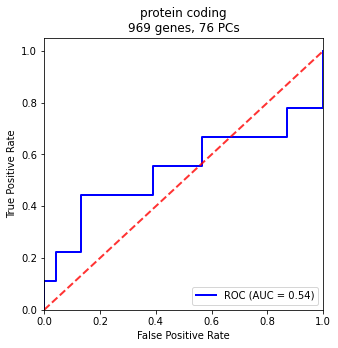

In [497]:
pca_svm_filter(df_0, ens, 'protein_coding', outname='protein_coding_pca_filter_0')

{'C': 10.0, 'gamma': 0.001, 'kernel': 'linear'}


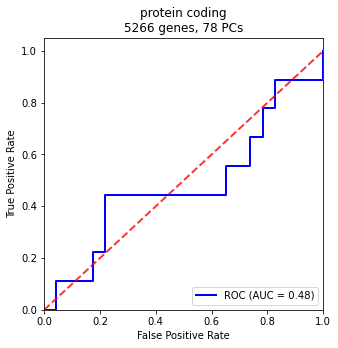

In [498]:
pca_svm_filter(df_5, ens, 'protein_coding', outname='protein_coding_pca_filter_5')

{'C': 0.0001, 'gamma': 0.05, 'kernel': 'sigmoid'}


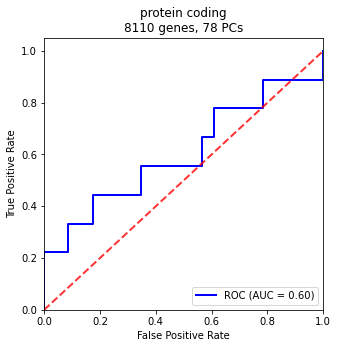

In [499]:
pca_svm_filter(df_10, ens, 'protein_coding', outname='protein_coding_pca_filter_10')

{'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}


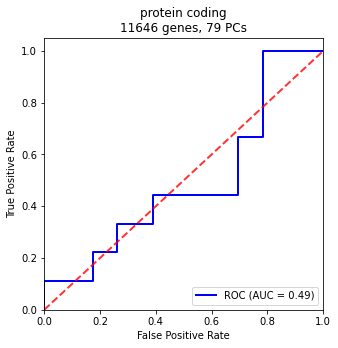

In [500]:
pca_svm_filter(df_20, ens, 'protein_coding', outname='protein_coding_pca_filter_20')

{'C': 0.0001, 'gamma': 0.1, 'kernel': 'sigmoid'}


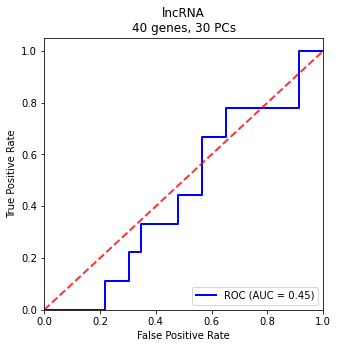

In [501]:
pca_svm_filter(df_0, ens, 'lncRNA', outname='lncRNA_pca_filter_0')

{'C': 0.001, 'gamma': 0.05, 'kernel': 'rbf'}


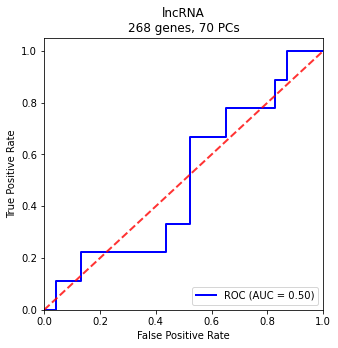

In [502]:
pca_svm_filter(df_5, ens, 'lncRNA', outname='lncRNA_pca_filter_5')

{'C': 100.0, 'gamma': 0.05, 'kernel': 'sigmoid'}


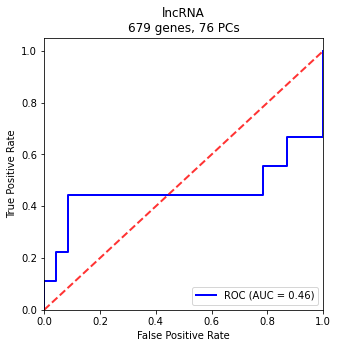

In [503]:
pca_svm_filter(df_10, ens, 'lncRNA', outname='lncRNA_pca_filter_10')

{'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}


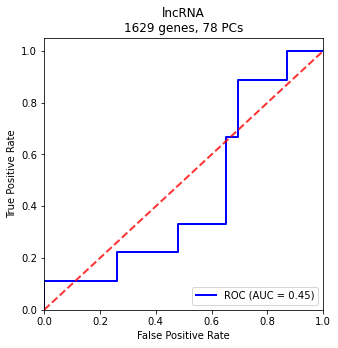

In [504]:
pca_svm_filter(df_20, ens, 'lncRNA', outname='lncRNA_pca_filter_20')

In [491]:
def pca_svm(dat, ens, biot):
    df_sel = dat.loc[ens[ens['Gene type'] == biot]['Gene stable ID'],]
    X = df_sel.iloc[:,:].T
    y = np.concatenate((np.ones(28, dtype=int), np.zeros(68, dtype=int)), axis=None)

    X = StandardScaler().fit_transform(X)

    # Run classifier with cross-validation and plot ROC curves
    pca = PCA(n_components=0.95, whiten=True).fit(X)
    X = pca.transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=32)
    
    search_space = [{'kernel': ['linear', 'rbf', 'sigmoid'],
                     'C': np.logspace(-4, 2, 7),
                     'gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1]}]
    svm = SVC(max_iter=1000, random_state=42, probability=True)
    clf = GridSearchCV(estimator=svm, param_grid=search_space, scoring='roc_auc_ovr', 
                   cv=StratifiedKFold(n_splits=5), refit=True, verbose=0)
    clf.fit(X_train, y_train)
    print(clf.cv_results_['params'][np.argmin(clf.cv_results_['rank_test_score'])])

    fig, ax = plt.subplots(figsize=(5,5))
    plot_roc_curve(clf, X_test, y_test, ax=ax, color='blue', lw=2, name='ROC')

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('{}\n{} genes, {} PCs'.format(biot.replace('_',' '), df_sel.shape[0], pca.n_components_))
    ax.legend(loc='lower right')
    plt.savefig("{}_pca_roc.png".format(biot))
    plt.show()

In [449]:
# ## Load DE genes
# degenes = pd.read_csv("p_values_of_pc_genes_5_or_less_zeros.csv", sep=',', header=0)
# print(degenes.shape)
# degenes.head()

In [450]:
# Load DE genes
degenes_0 = pd.read_csv("p_values_of_pc_and_lncrna_genes_0_or_less_zeros.csv", sep=',', header=0)
print(degenes_0.shape)
degenes_0.head()

(1009, 7)


,Unnamed: 0,pvalues,diffs,index,Gene_ID,bh,significant
0,1,0.000964,6.209719,470,ENSG00000138640,0.00005,True
1,2,0.000964,6.912786,927,ENSG00000198791,0.00005,True
2,3,0.001050,-6.941723,394,ENSG00000131374,0.00005,True
3,4,0.002343,5.952616,505,ENSG00000143469,0.00005,True
4,5,0.003662,7.278807,999,ENSG00000272047,0.00005,True


{'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}


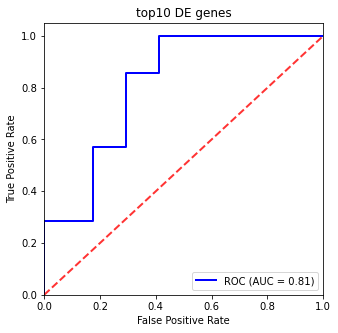

0.8067226890756303

In [545]:
svm_top_feat(df_0, degenes_0.head(10)['Gene_ID'], outname='images/top10_DE_0_svm')

{'C': 1.0, 'gamma': 0.05, 'kernel': 'rbf'}


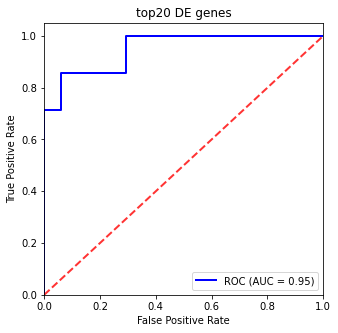

0.9495798319327731

In [546]:
svm_top_feat(df_0, degenes_0.head(20)['Gene_ID'], outname='images/top20_DE_0_svm')

{'C': 1.0, 'gamma': 0.01, 'kernel': 'sigmoid'}


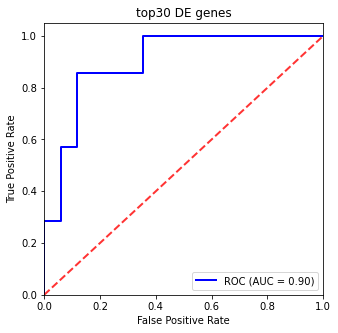

0.8991596638655461

In [547]:
svm_top_feat(df_0, degenes_0.head(30)['Gene_ID'], outname='top30_DE_0_svm')

In [448]:
degenes_5 = pd.read_csv("p_values_of_pc_and_lncrna_genes_5_or_less_zeros.csv", sep=',', header=0)
print(degenes_5.shape)
degenes_5.head()

(5534, 7)


,Unnamed: 0,pvalues,diffs,index,Gene_ID,bh,significant
0,1,0.000133,8.697621,5193,ENSG00000216937,0.000009,True
1,2,0.000428,8.226618,376,ENSG00000066279,0.000009,True
2,3,0.000508,3.691049,1890,ENSG00000124588,0.000009,True
3,4,0.000893,6.625028,1827,ENSG00000122786,0.000009,True
4,5,0.000964,6.209719,2510,ENSG00000138640,0.000009,True


{'C': 100.0, 'gamma': 0.01, 'kernel': 'rbf'}


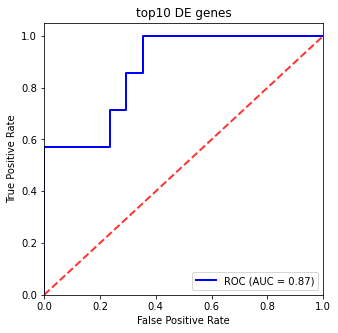

0.8739495798319328

In [550]:
svm_top_feat(df_5, degenes_5.head(10)['Gene_ID'], outname='images/top10_DE_5_svm')

{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}


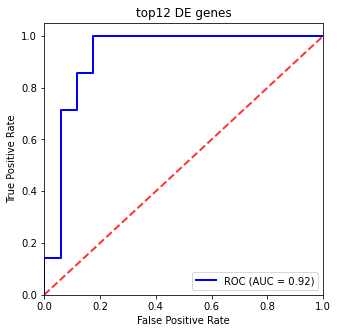

0.9243697478991597

In [549]:
svm_top_feat(df_5, degenes_5.head(12)['Gene_ID'], outname='images/top12_DE_5_svm')

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}


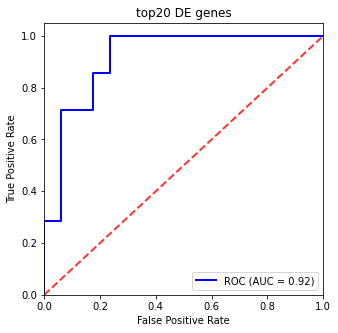

0.9159663865546218

In [551]:
svm_top_feat(df_5, degenes_5.head(20)['Gene_ID'], outname='images/top20_DE_5_svm')

{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}


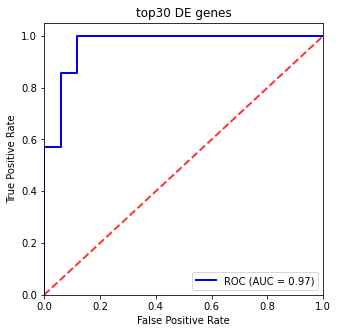

In [464]:
svm_top_feat(df, degenes_5.head(30)['Gene_ID'], outname='top30_DE_5_svm')

{'C': 1.0, 'gamma': 0.01, 'kernel': 'sigmoid'}


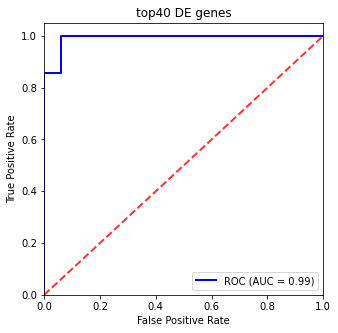

In [465]:
svm_top_feat(df, degenes_5.head(40)['Gene_ID'], outname='top40_DE_5_svm')

In [451]:
degenes_10 = pd.read_csv("p_values_of_pc_and_lncrna_genes_10_or_less_zeros.csv", sep=',', header=0)
print(degenes_10.shape)
degenes_10.head()

(8789, 7)


,Unnamed: 0,pvalues,diffs,index,Gene_ID,bh,significant
0,1,0.000133,8.697621,7992,ENSG00000216937,0.000006,True
1,2,0.000428,8.226618,563,ENSG00000066279,0.000006,True
2,3,0.000508,3.691049,2853,ENSG00000124588,0.000006,True
3,4,0.000537,11.554644,8063,ENSG00000226869,0.000006,True
4,5,0.000805,4.672809,6666,ENSG00000177302,0.000006,True


{'C': 10.0, 'gamma': 0.01, 'kernel': 'sigmoid'}


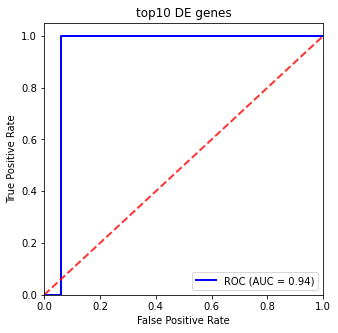

In [468]:
svm_top_feat(df, degenes_10.head(10)['Gene_ID'], outname='top10_DE_10_svm')

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}


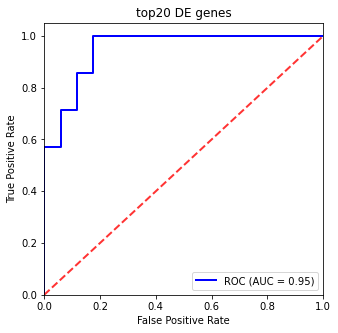

In [469]:
svm_top_feat(df, degenes_10.head(20)['Gene_ID'], outname='top20_DE_10_svm')

{'C': 10.0, 'gamma': 0.05, 'kernel': 'sigmoid'}


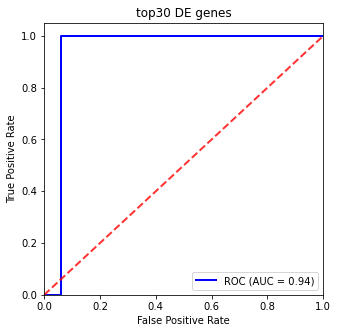

In [470]:
svm_top_feat(df, degenes_10.head(30)['Gene_ID'], outname='top30_DE_10_svm')

In [452]:
degenes_20 = pd.read_csv("p_values_of_pc_and_lncrna_genes_20_or_less_zeros.csv", sep=',', header=0)
print(degenes_20.shape)
degenes_20.head()

(13275, 7)


,Unnamed: 0,pvalues,diffs,index,Gene_ID,bh,significant
0,1,0.000133,8.697621,11426,ENSG00000216937,0.000004,True
1,2,0.000255,12.907999,8456,ENSG00000168564,0.000004,True
2,3,0.000428,8.226618,755,ENSG00000066279,0.000004,True
3,4,0.000508,3.691049,3964,ENSG00000124588,0.000004,True
4,5,0.000537,11.554644,11585,ENSG00000226869,0.000004,True


{'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}


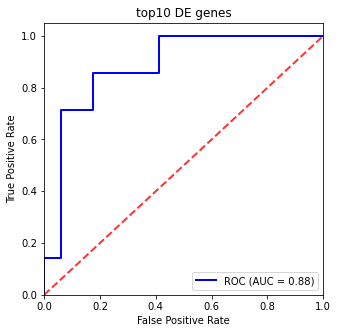

In [471]:
svm_top_feat(df, degenes_20.head(10)['Gene_ID'], outname='top10_DE_20_svm')

{'C': 100.0, 'gamma': 0.1, 'kernel': 'sigmoid'}


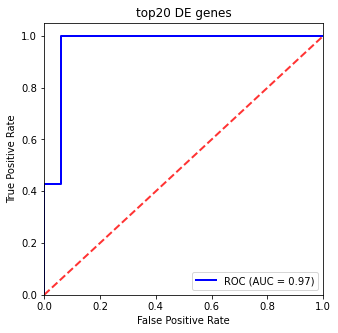

In [472]:
svm_top_feat(df, degenes_20.head(20)['Gene_ID'], outname='top20_DE_20_svm')

{'C': 0.0001, 'gamma': 0.01, 'kernel': 'sigmoid'}


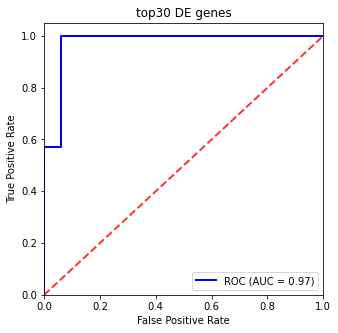

In [473]:
svm_top_feat(df, degenes_20.head(30)['Gene_ID'], outname='top30_DE_20_svm')

{'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'}


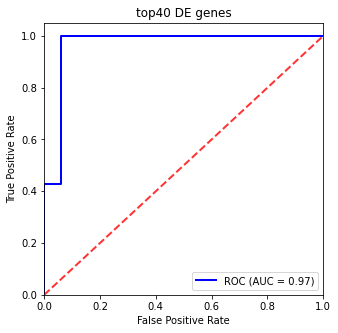

In [474]:
svm_top_feat(df, degenes_20.head(40)['Gene_ID'], outname='top40_DE_20_svm')

In [221]:
# indices of training set - created by traint_test_split with random seed 42
# 72 training samples
# np.sort(ind)

array([ 0,  2,  4,  5,  6,  7,  8, 10, 12, 14, 15, 16, 18, 19, 20, 21, 22,
       23, 24, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 43,
       44, 45, 47, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 81, 82, 83, 84, 86, 89, 91,
       92, 93, 94, 95])

{'C': 100.0, 'gamma': 0.01, 'kernel': 'rbf'}


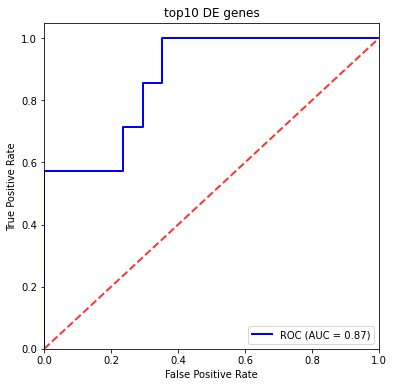

In [390]:
# Using top 10 DE genes - pretty good result
# svm_top_feat(df, degenes.head(10)['Gene_ID'])

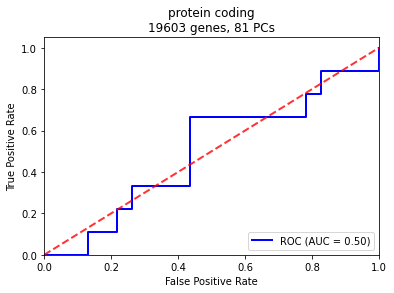

In [293]:
pca_svm(df, ens, 'protein_coding')

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'linear'}


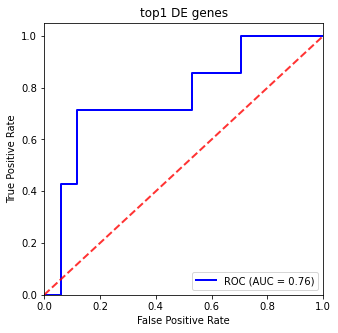

{'C': 0.001, 'gamma': 0.5, 'kernel': 'rbf'}


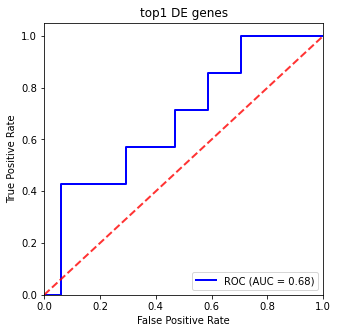

{'C': 0.001, 'gamma': 0.5, 'kernel': 'rbf'}


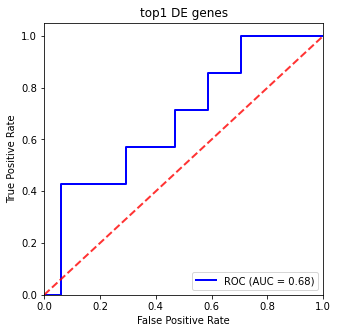

{'C': 0.001, 'gamma': 0.5, 'kernel': 'rbf'}


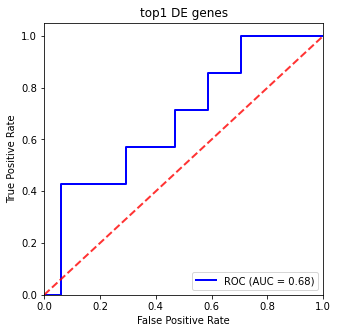

{'C': 100.0, 'gamma': 0.5, 'kernel': 'rbf'}


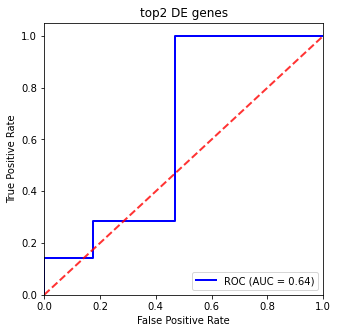

{'C': 0.001, 'gamma': 0.5, 'kernel': 'sigmoid'}


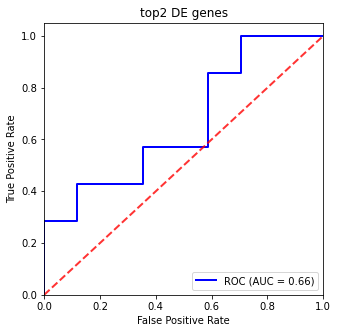

{'C': 0.001, 'gamma': 0.5, 'kernel': 'sigmoid'}


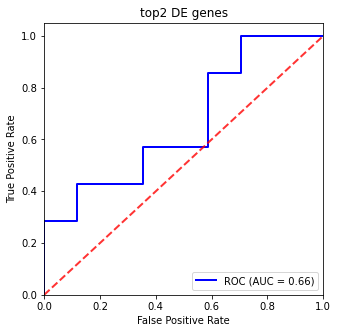

{'C': 1.0, 'gamma': 0.5, 'kernel': 'sigmoid'}


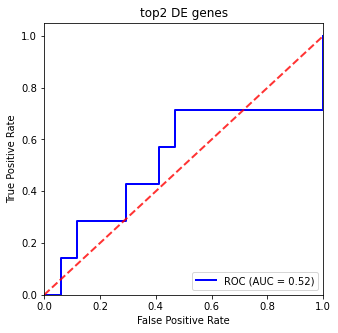

{'C': 0.0001, 'gamma': 1, 'kernel': 'rbf'}


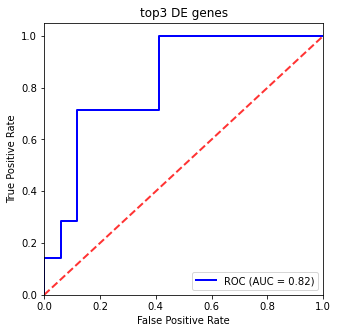

{'C': 0.0001, 'gamma': 1, 'kernel': 'rbf'}


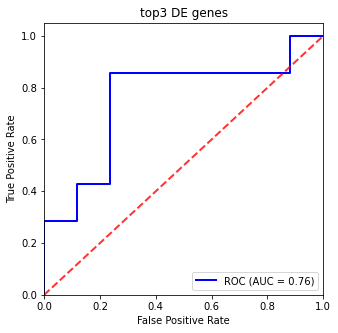

{'C': 0.0001, 'gamma': 1, 'kernel': 'rbf'}


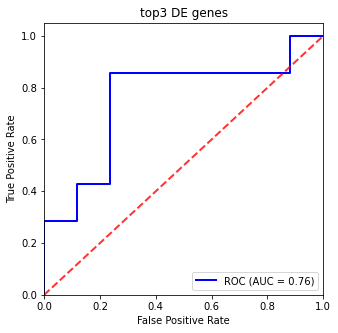

{'C': 1.0, 'gamma': 0.5, 'kernel': 'sigmoid'}


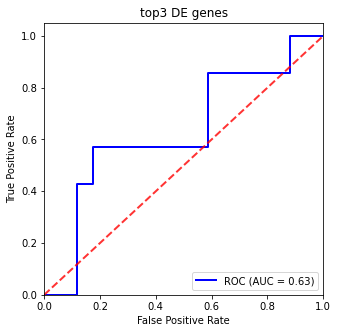

{'C': 10.0, 'gamma': 0.5, 'kernel': 'rbf'}


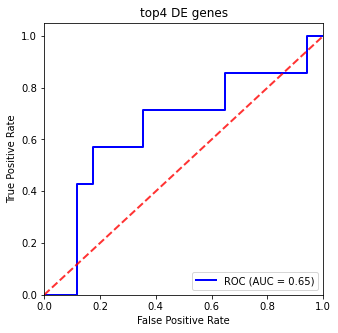

{'C': 0.0001, 'gamma': 0.05, 'kernel': 'rbf'}


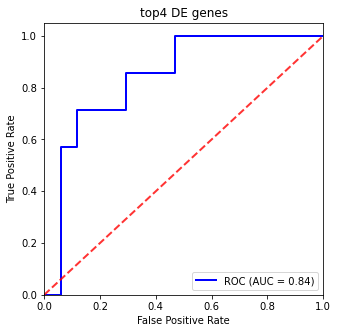

{'C': 0.0001, 'gamma': 0.05, 'kernel': 'rbf'}


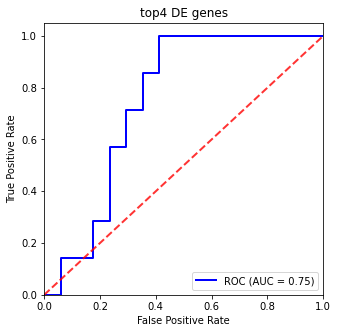

{'C': 0.0001, 'gamma': 0.05, 'kernel': 'sigmoid'}


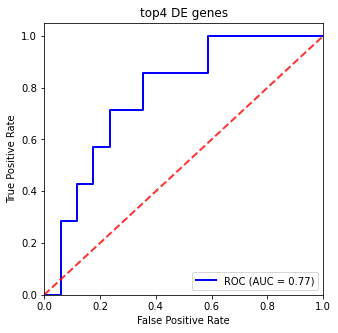

{'C': 0.01, 'gamma': 0.5, 'kernel': 'rbf'}


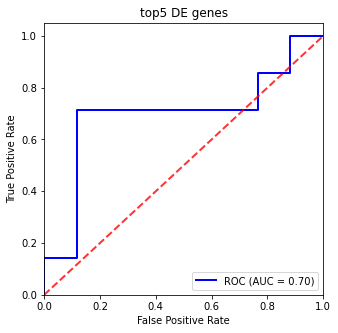

{'C': 0.0001, 'gamma': 0.1, 'kernel': 'rbf'}


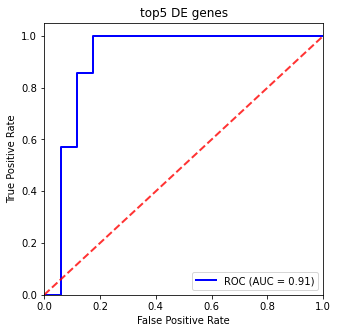

{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}


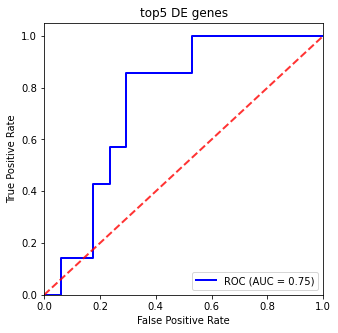

{'C': 0.0001, 'gamma': 0.1, 'kernel': 'rbf'}


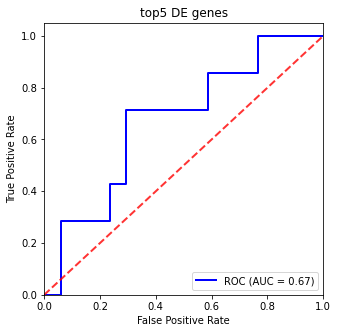

{'C': 100.0, 'gamma': 0.001, 'kernel': 'rbf'}


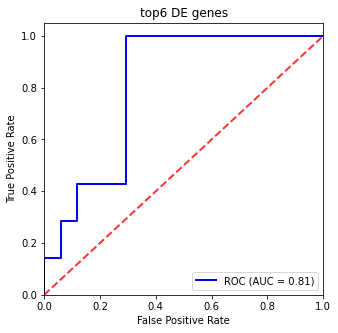

{'C': 0.0001, 'gamma': 0.05, 'kernel': 'rbf'}


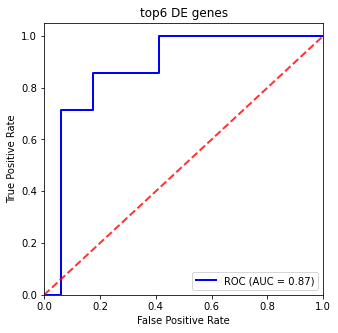

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'linear'}


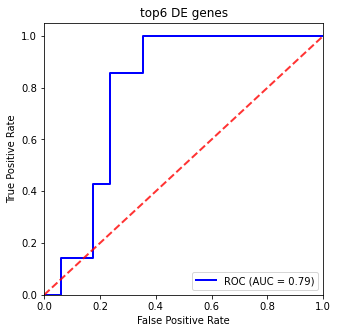

{'C': 100.0, 'gamma': 0.001, 'kernel': 'rbf'}


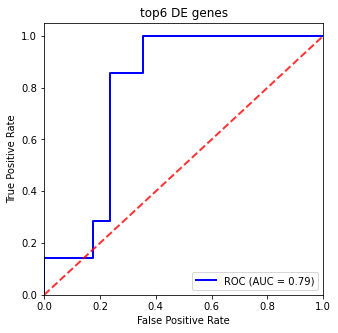

{'C': 0.01, 'gamma': 0.5, 'kernel': 'rbf'}


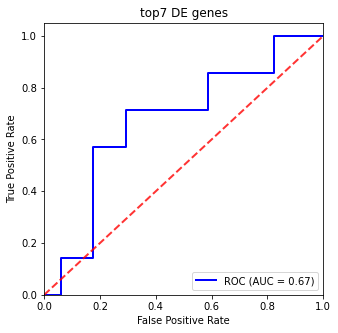

{'C': 0.0001, 'gamma': 0.1, 'kernel': 'rbf'}


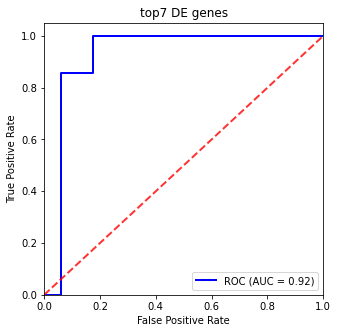

{'C': 0.0001, 'gamma': 0.05, 'kernel': 'sigmoid'}


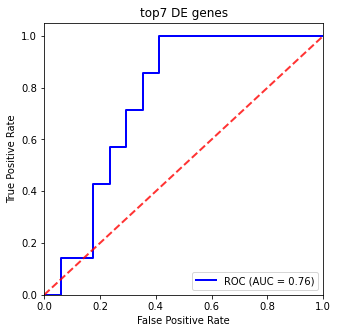

{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}


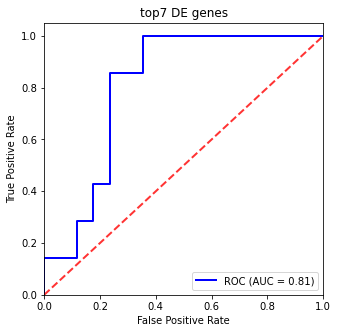

{'C': 100.0, 'gamma': 0.001, 'kernel': 'rbf'}


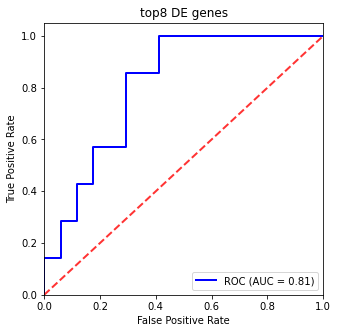

{'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}


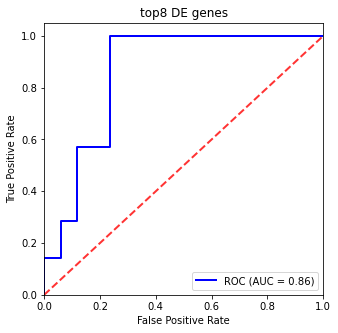

{'C': 0.0001, 'gamma': 0.05, 'kernel': 'sigmoid'}


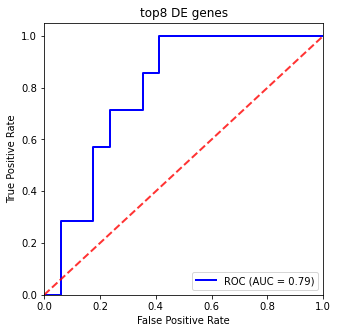

{'C': 1.0, 'gamma': 0.05, 'kernel': 'sigmoid'}


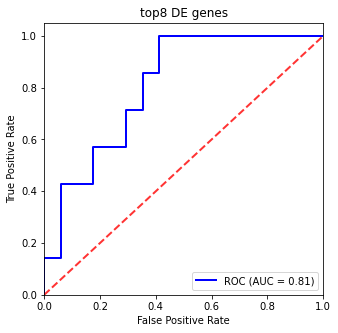

{'C': 1.0, 'gamma': 0.001, 'kernel': 'linear'}


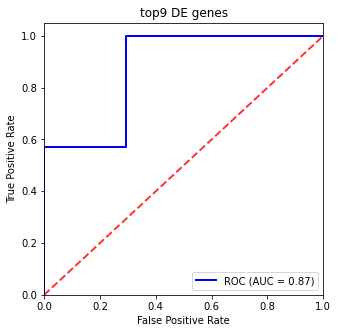

{'C': 10.0, 'gamma': 0.05, 'kernel': 'rbf'}


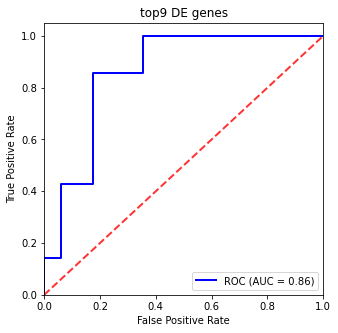

{'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}


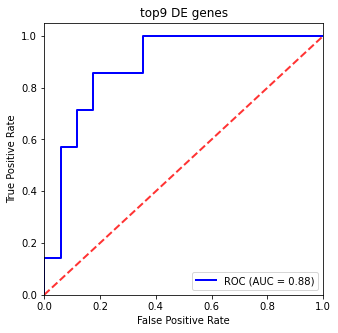

{'C': 0.0001, 'gamma': 0.05, 'kernel': 'sigmoid'}


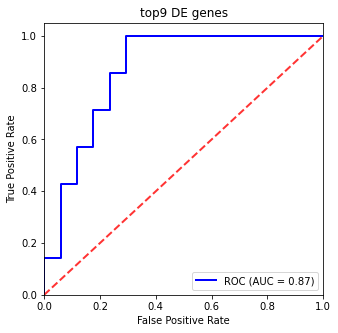

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}


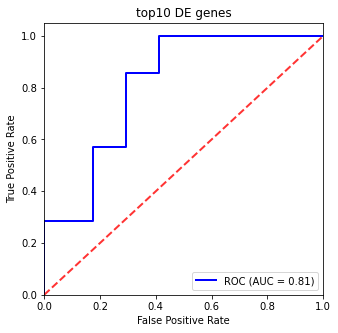

{'C': 100.0, 'gamma': 0.01, 'kernel': 'rbf'}


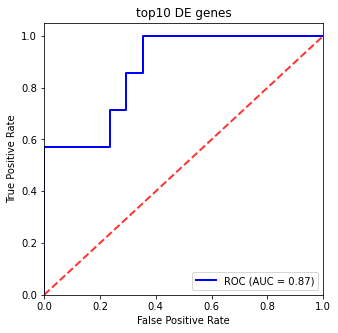

{'C': 10.0, 'gamma': 0.01, 'kernel': 'sigmoid'}


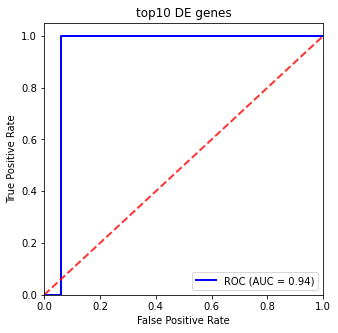

{'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}


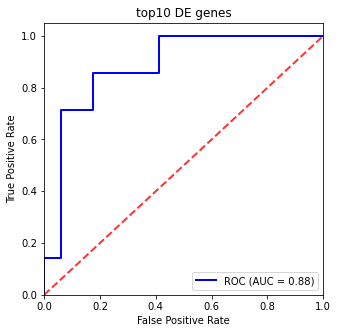

{'C': 0.001, 'gamma': 0.05, 'kernel': 'sigmoid'}


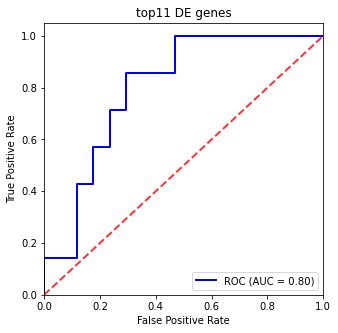

{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}


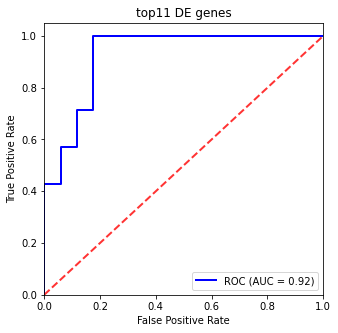

{'C': 1.0, 'gamma': 0.001, 'kernel': 'linear'}


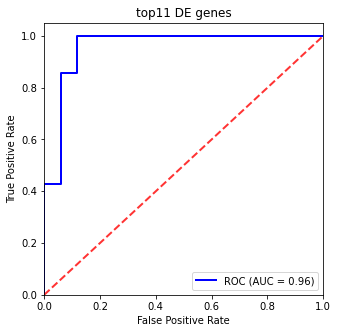

{'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}


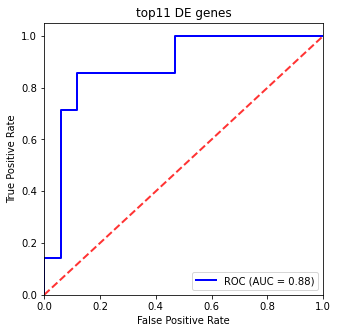

{'C': 0.001, 'gamma': 0.1, 'kernel': 'sigmoid'}


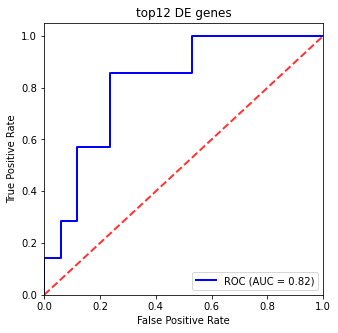

{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}


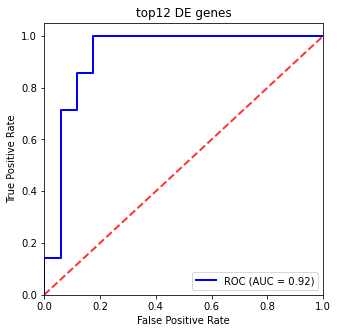

{'C': 100.0, 'gamma': 0.05, 'kernel': 'sigmoid'}


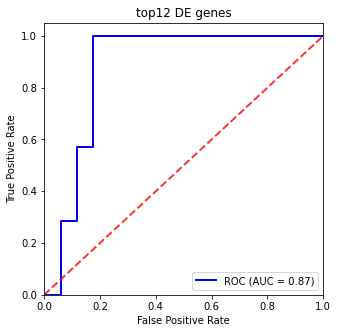

{'C': 0.0001, 'gamma': 0.05, 'kernel': 'sigmoid'}


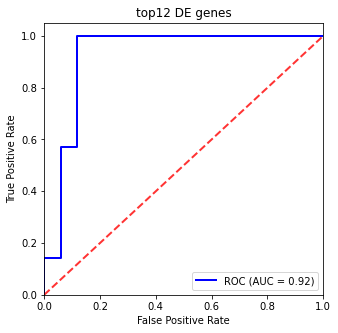

{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}


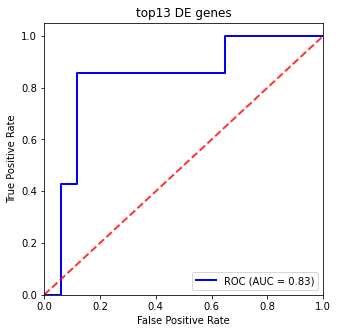

{'C': 0.0001, 'gamma': 0.05, 'kernel': 'rbf'}


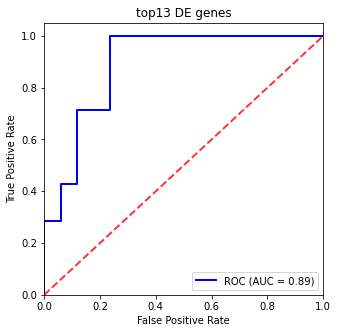

{'C': 1.0, 'gamma': 0.1, 'kernel': 'sigmoid'}


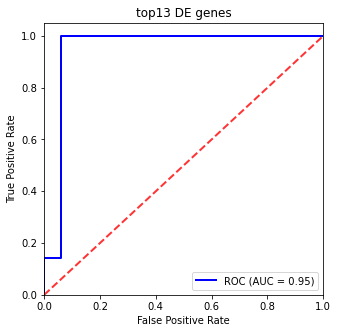

{'C': 100.0, 'gamma': 0.001, 'kernel': 'rbf'}


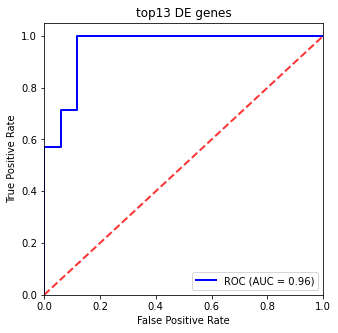

{'C': 0.01, 'gamma': 0.05, 'kernel': 'sigmoid'}


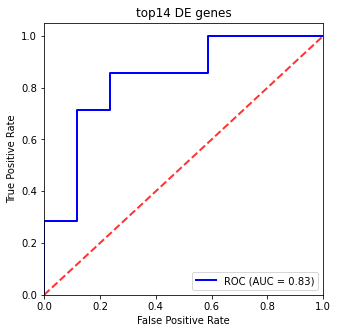

{'C': 0.001, 'gamma': 1, 'kernel': 'sigmoid'}


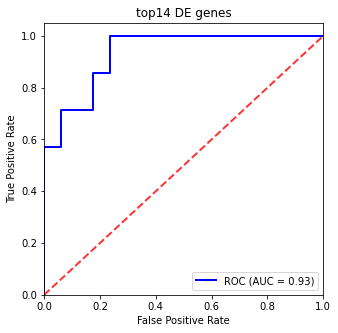

{'C': 0.0001, 'gamma': 0.05, 'kernel': 'sigmoid'}


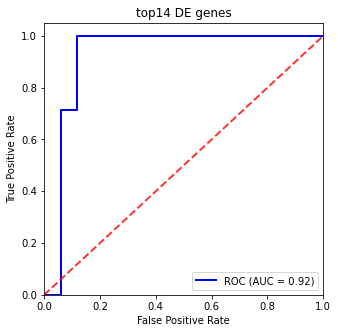

{'C': 1.0, 'gamma': 0.05, 'kernel': 'sigmoid'}


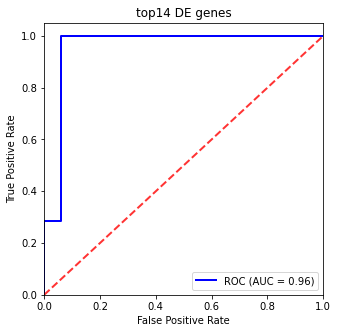

{'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}


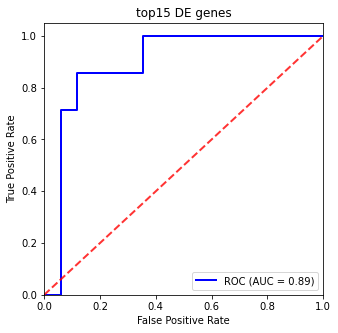

{'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}


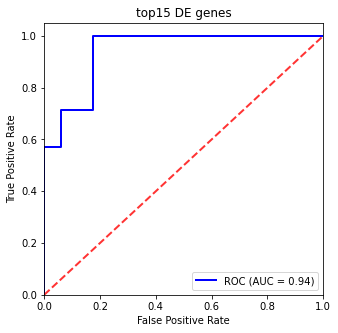

{'C': 0.0001, 'gamma': 0.05, 'kernel': 'rbf'}


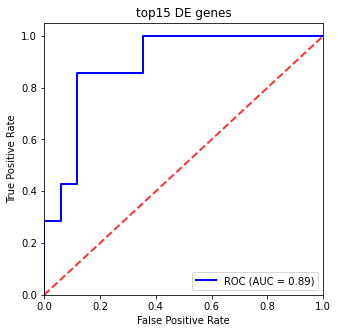

{'C': 1.0, 'gamma': 0.1, 'kernel': 'sigmoid'}


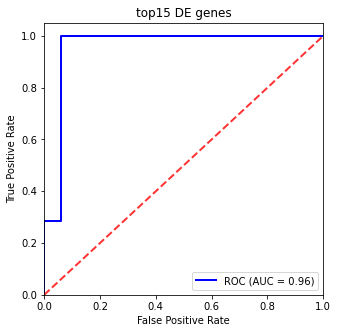

{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}


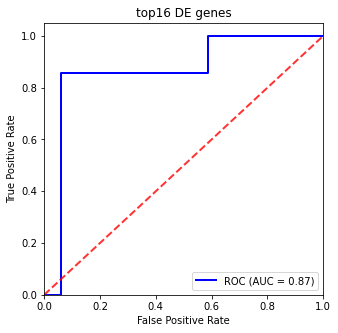

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'sigmoid'}


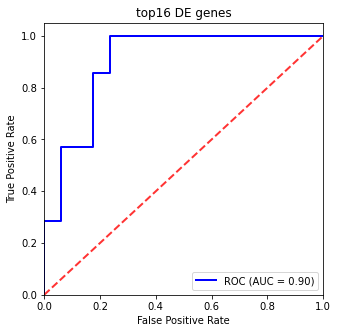

{'C': 10.0, 'gamma': 0.05, 'kernel': 'sigmoid'}


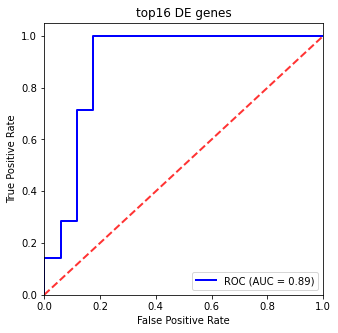

{'C': 10.0, 'gamma': 0.05, 'kernel': 'sigmoid'}


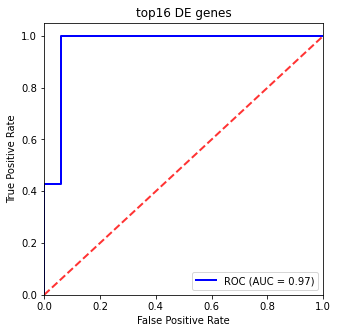

{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}


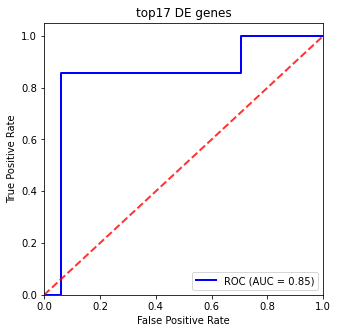

{'C': 0.0001, 'gamma': 0.05, 'kernel': 'sigmoid'}


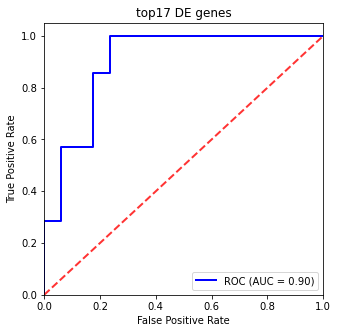

{'C': 0.0001, 'gamma': 0.05, 'kernel': 'sigmoid'}


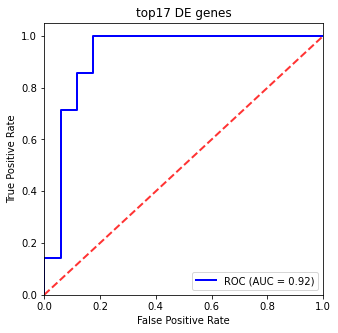

{'C': 1.0, 'gamma': 0.05, 'kernel': 'sigmoid'}


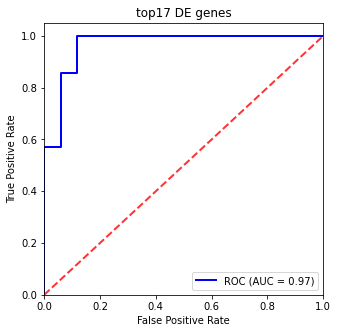

{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}


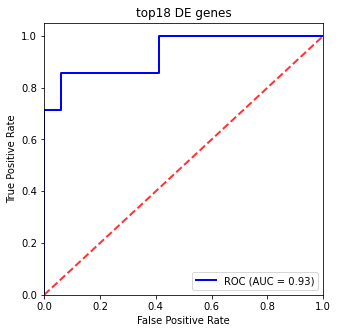

{'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}


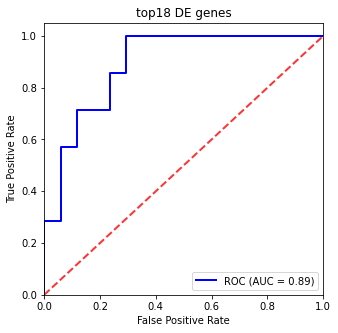

{'C': 1.0, 'gamma': 0.001, 'kernel': 'linear'}


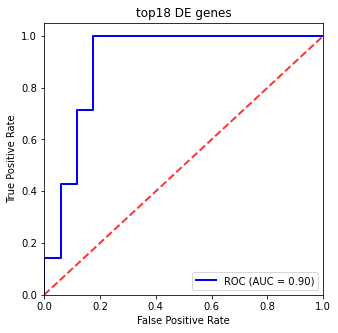

{'C': 10.0, 'gamma': 0.01, 'kernel': 'sigmoid'}


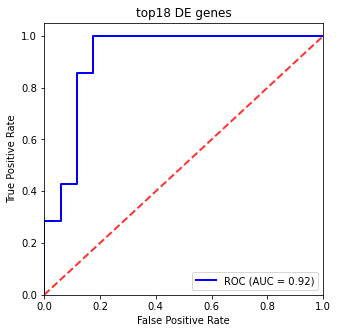

{'C': 1.0, 'gamma': 0.05, 'kernel': 'rbf'}


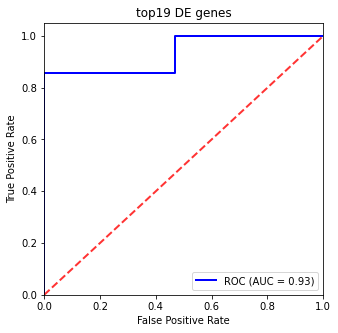

{'C': 0.001, 'gamma': 0.001, 'kernel': 'linear'}


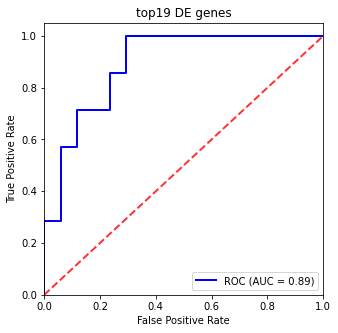

{'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}


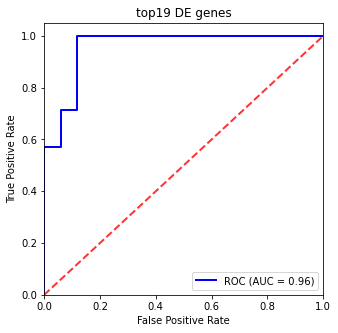

{'C': 10.0, 'gamma': 0.1, 'kernel': 'sigmoid'}


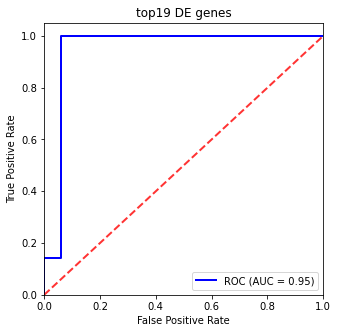

{'C': 1.0, 'gamma': 0.05, 'kernel': 'rbf'}


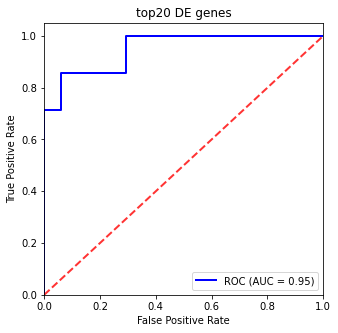

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}


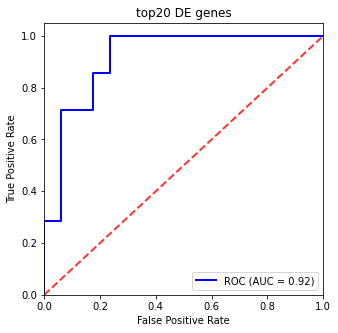

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}


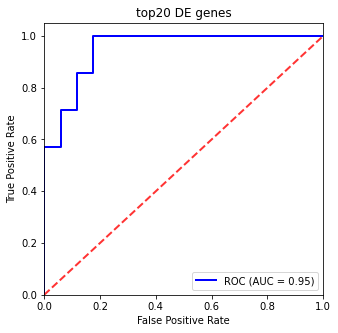

{'C': 100.0, 'gamma': 0.1, 'kernel': 'sigmoid'}


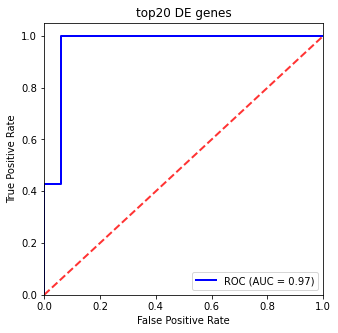

{'C': 1.0, 'gamma': 0.05, 'kernel': 'rbf'}


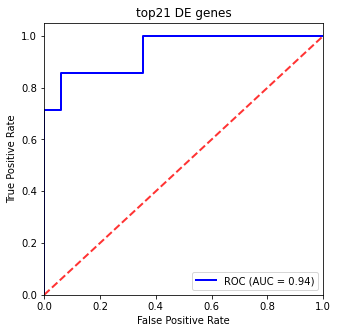

{'C': 0.0001, 'gamma': 0.01, 'kernel': 'sigmoid'}


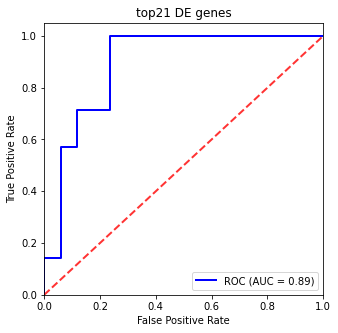

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'linear'}


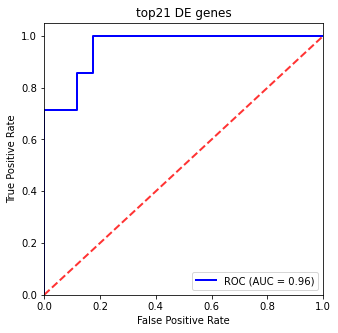

{'C': 100.0, 'gamma': 0.1, 'kernel': 'sigmoid'}


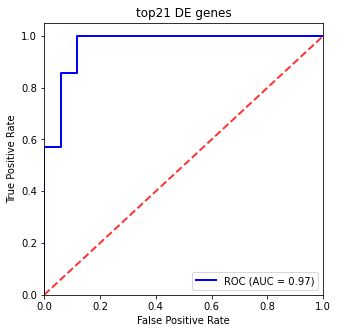

{'C': 1.0, 'gamma': 0.05, 'kernel': 'rbf'}


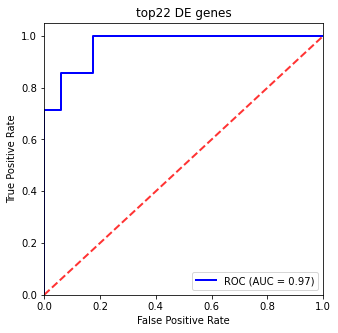

{'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}


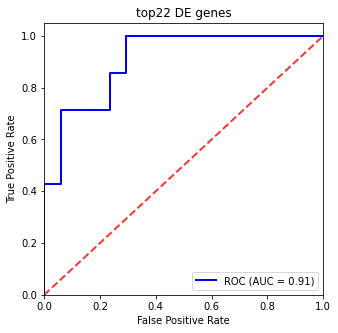

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}


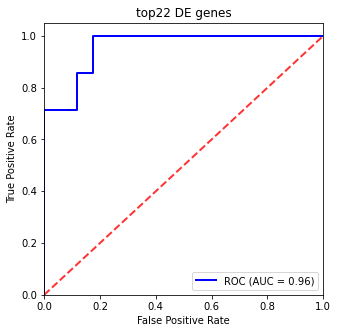

{'C': 10.0, 'gamma': 0.05, 'kernel': 'sigmoid'}


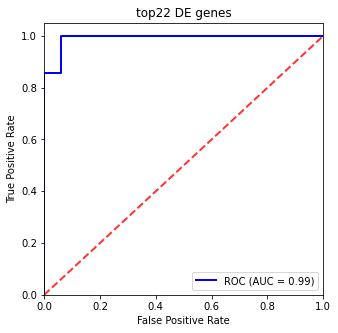

{'C': 1.0, 'gamma': 0.05, 'kernel': 'rbf'}


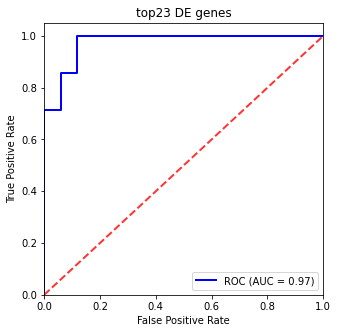

{'C': 0.001, 'gamma': 0.001, 'kernel': 'linear'}


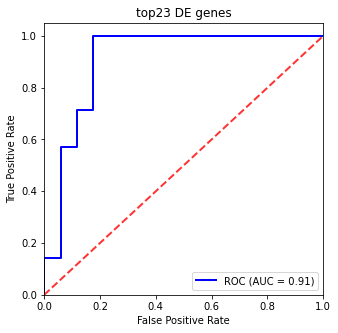

{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}


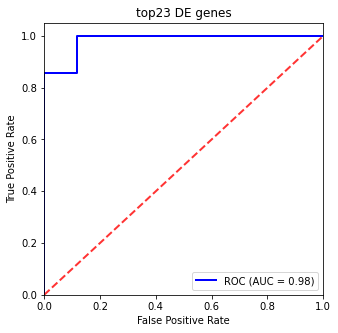

{'C': 100.0, 'gamma': 0.05, 'kernel': 'sigmoid'}


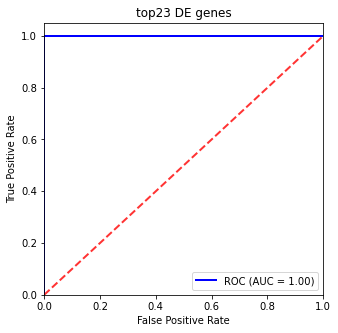

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}


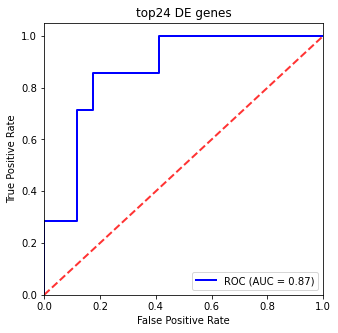

{'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}


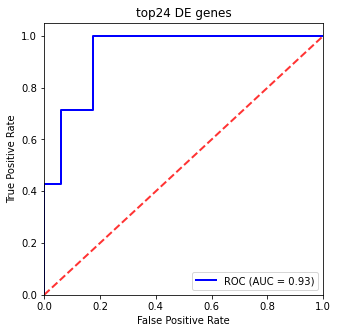

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}


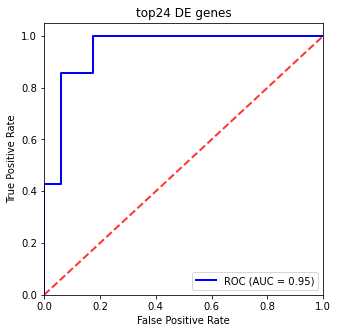

{'C': 100.0, 'gamma': 0.05, 'kernel': 'sigmoid'}


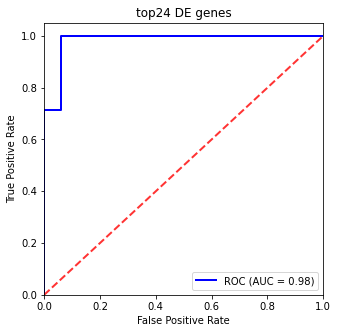

{'C': 0.01, 'gamma': 0.05, 'kernel': 'rbf'}


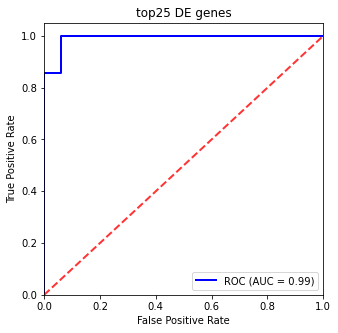

{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}


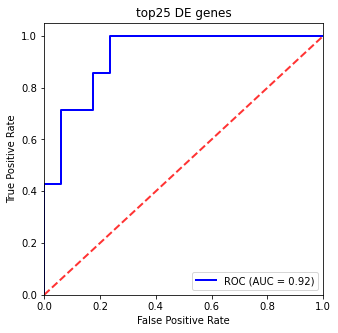

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'linear'}


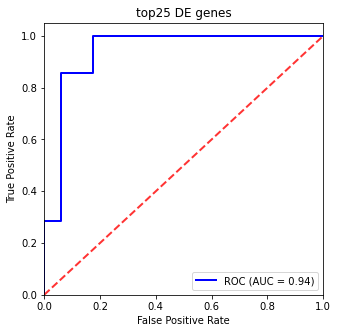

{'C': 10.0, 'gamma': 0.05, 'kernel': 'sigmoid'}


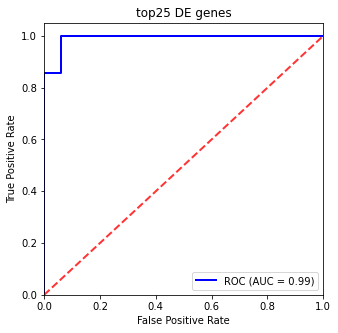

{'C': 0.01, 'gamma': 0.05, 'kernel': 'rbf'}


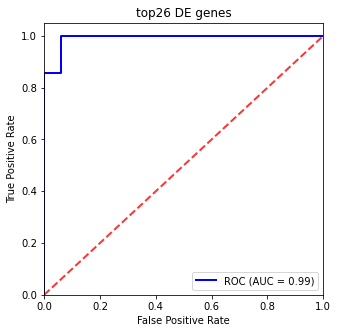

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}


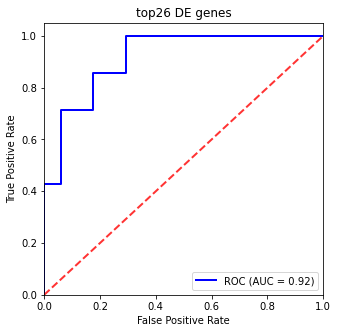

{'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}


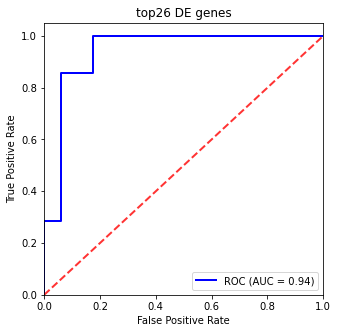

{'C': 10.0, 'gamma': 0.05, 'kernel': 'sigmoid'}


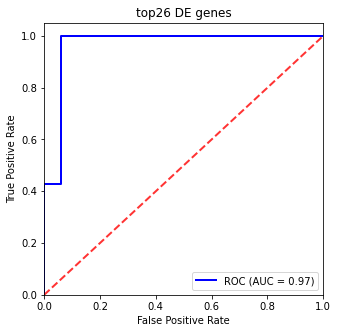

{'C': 0.001, 'gamma': 0.05, 'kernel': 'sigmoid'}


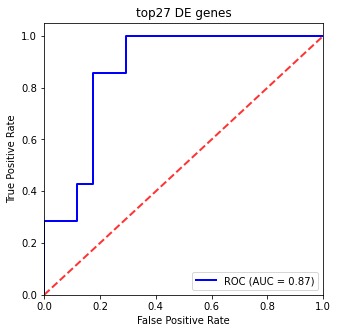

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}


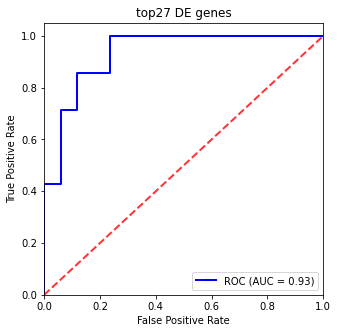

{'C': 0.0001, 'gamma': 0.05, 'kernel': 'sigmoid'}


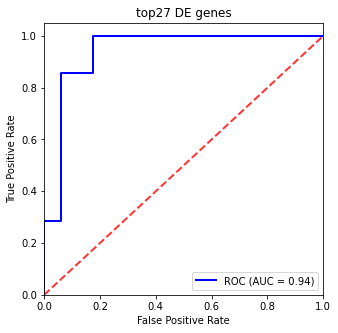

{'C': 10.0, 'gamma': 0.05, 'kernel': 'sigmoid'}


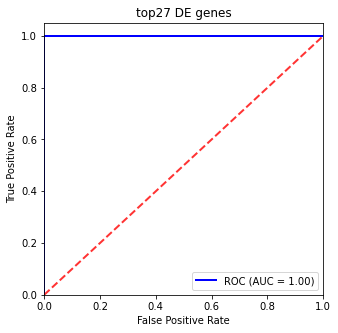

{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}


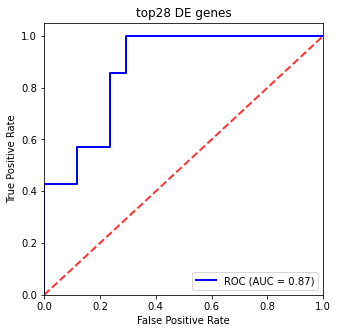

{'C': 0.0001, 'gamma': 0.1, 'kernel': 'sigmoid'}


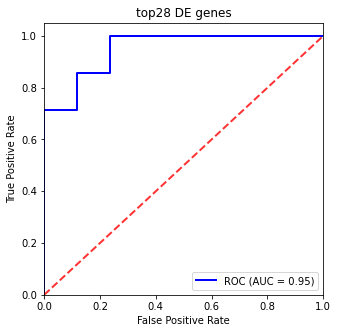

{'C': 0.0001, 'gamma': 0.05, 'kernel': 'sigmoid'}


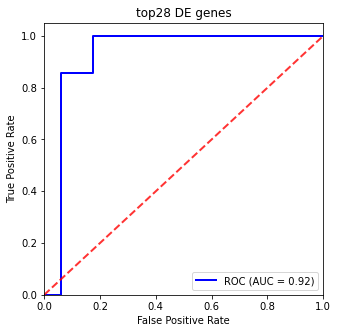

{'C': 0.001, 'gamma': 0.01, 'kernel': 'sigmoid'}


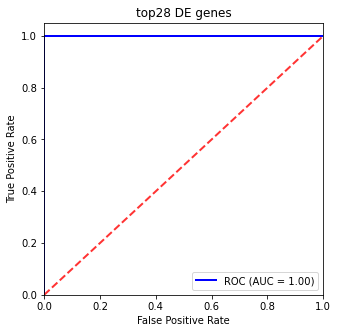

{'C': 0.001, 'gamma': 0.001, 'kernel': 'linear'}


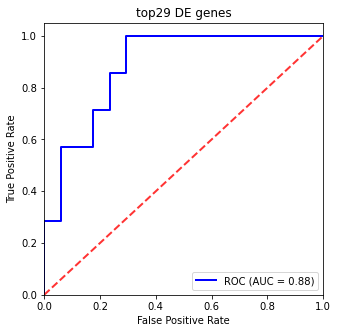

{'C': 0.001, 'gamma': 0.05, 'kernel': 'sigmoid'}


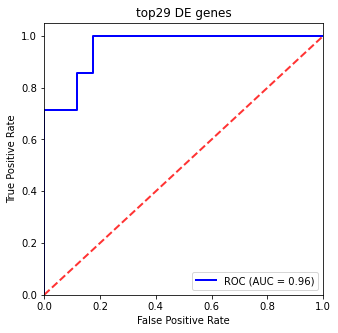

{'C': 0.001, 'gamma': 0.05, 'kernel': 'sigmoid'}


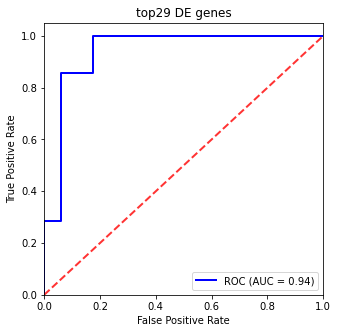

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}


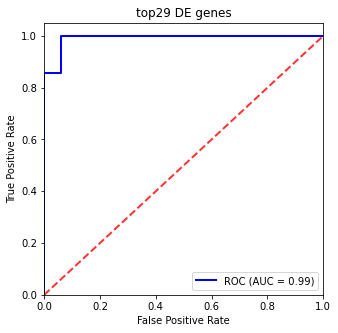

{'C': 1.0, 'gamma': 0.01, 'kernel': 'sigmoid'}


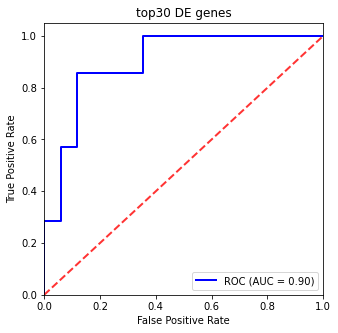

{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}


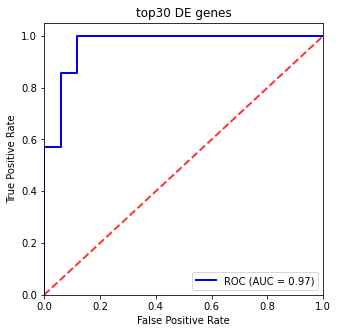

{'C': 10.0, 'gamma': 0.05, 'kernel': 'sigmoid'}


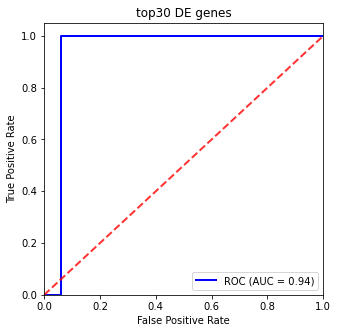

{'C': 0.0001, 'gamma': 0.01, 'kernel': 'sigmoid'}


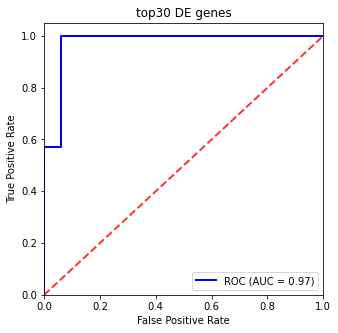

{'C': 1.0, 'gamma': 0.01, 'kernel': 'sigmoid'}


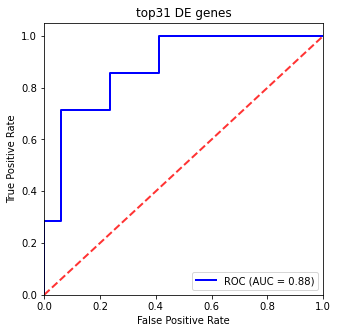

{'C': 0.01, 'gamma': 0.1, 'kernel': 'sigmoid'}


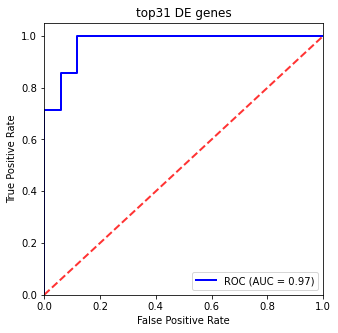

{'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}


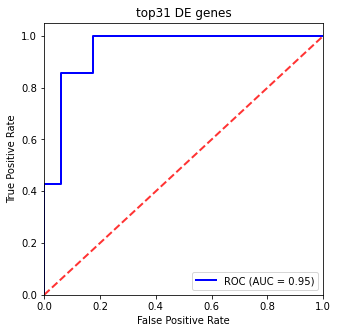

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'linear'}


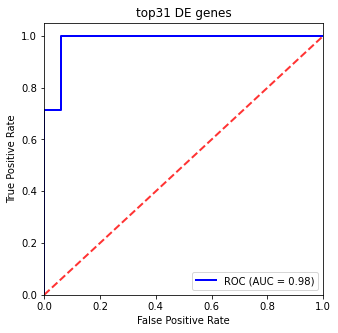

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'linear'}


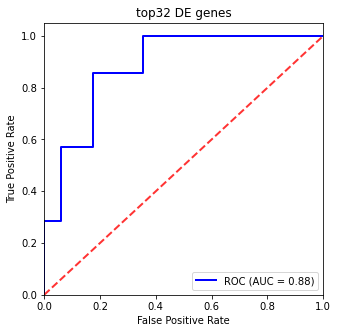

{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}


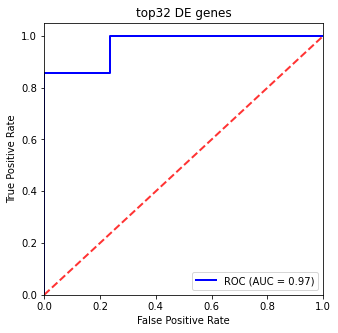

{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}


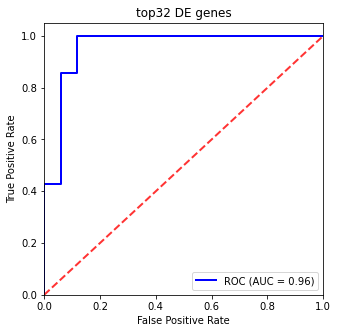

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'sigmoid'}


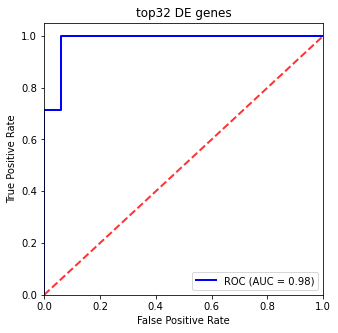

{'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}


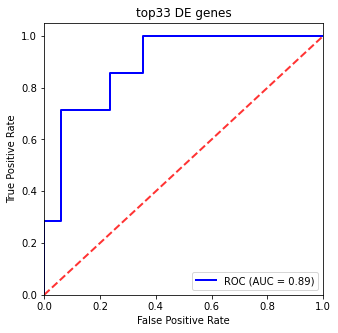

{'C': 0.0001, 'gamma': 0.01, 'kernel': 'sigmoid'}


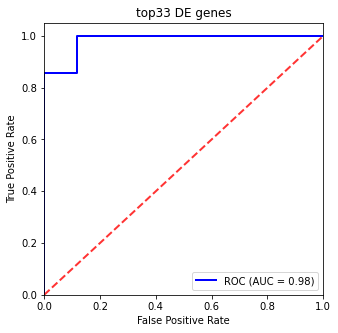

{'C': 1.0, 'gamma': 0.05, 'kernel': 'rbf'}


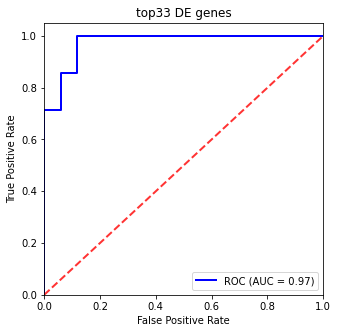

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'sigmoid'}


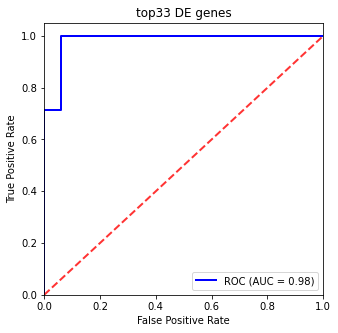

{'C': 0.001, 'gamma': 0.001, 'kernel': 'linear'}


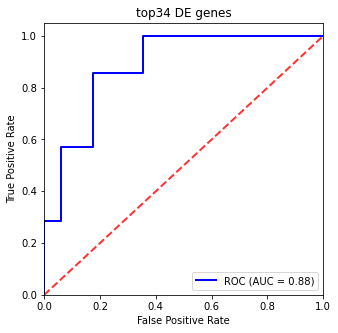

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'sigmoid'}


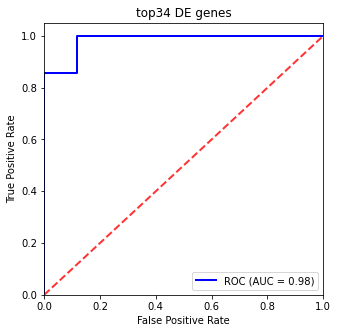

{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}


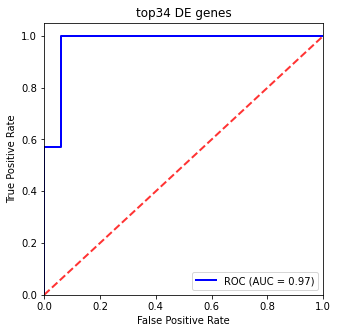

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}


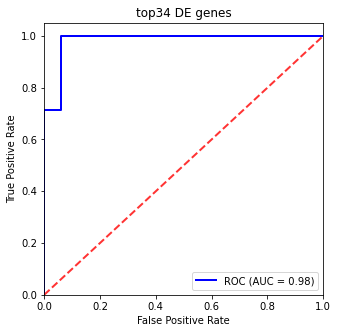

{'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}


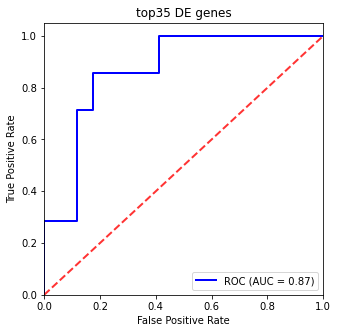

{'C': 0.0001, 'gamma': 0.1, 'kernel': 'sigmoid'}


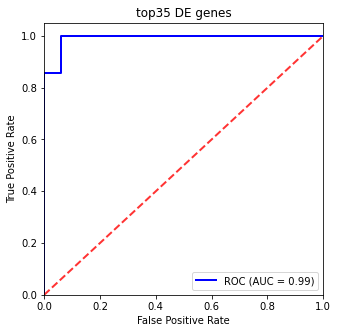

{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}


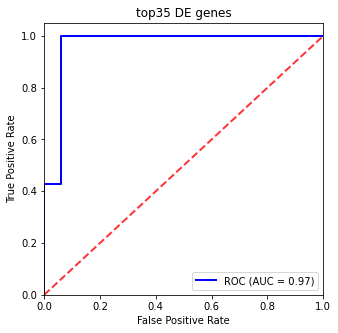

{'C': 0.0001, 'gamma': 0.05, 'kernel': 'sigmoid'}


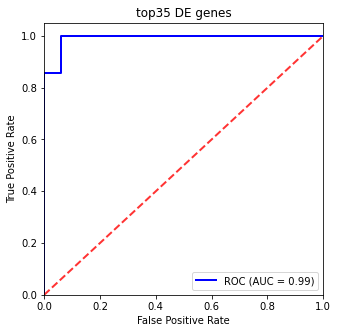

{'C': 0.001, 'gamma': 0.1, 'kernel': 'sigmoid'}


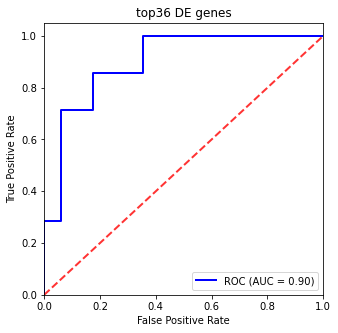

{'C': 0.0001, 'gamma': 0.5, 'kernel': 'sigmoid'}


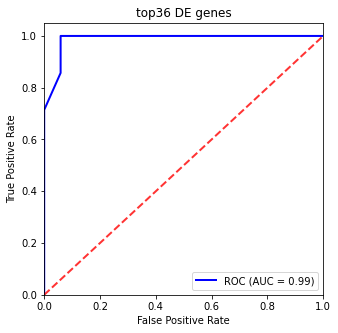

{'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'}


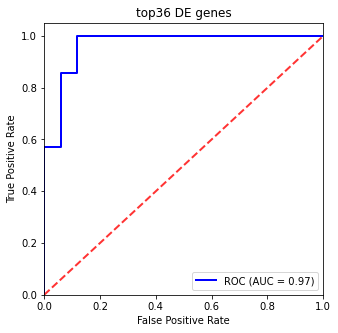

{'C': 0.0001, 'gamma': 0.05, 'kernel': 'sigmoid'}


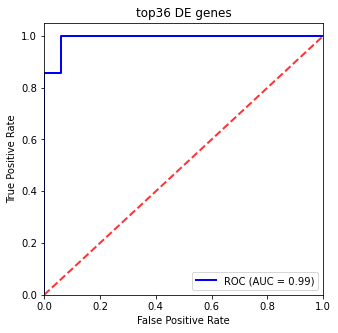

{'C': 1.0, 'gamma': 0.1, 'kernel': 'sigmoid'}


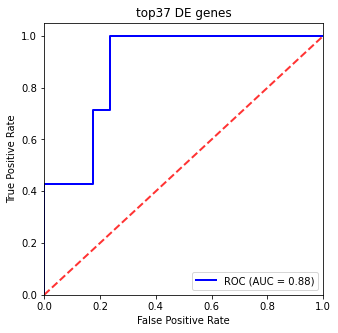

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}


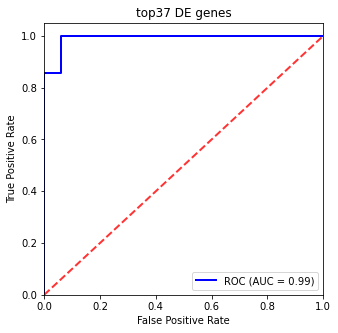

{'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}


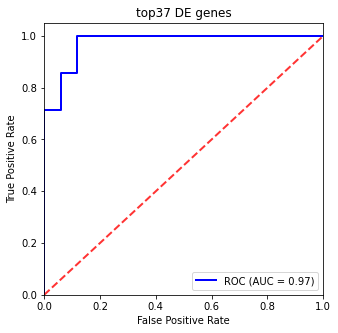

{'C': 0.0001, 'gamma': 0.05, 'kernel': 'sigmoid'}


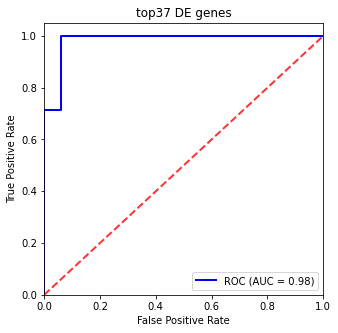

{'C': 1.0, 'gamma': 0.01, 'kernel': 'sigmoid'}


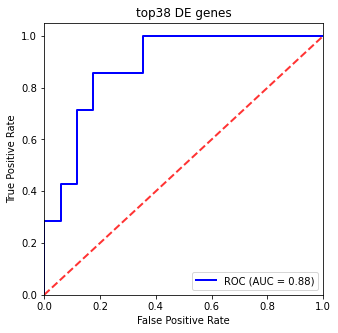

{'C': 0.001, 'gamma': 0.01, 'kernel': 'sigmoid'}


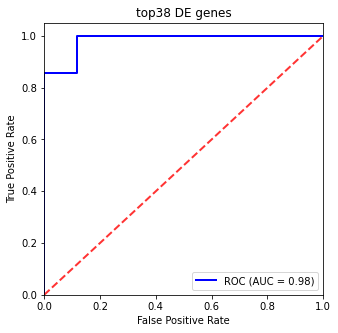

{'C': 1.0, 'gamma': 0.05, 'kernel': 'sigmoid'}


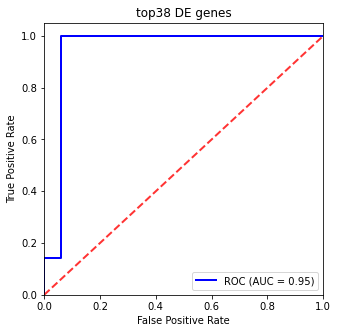

{'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}


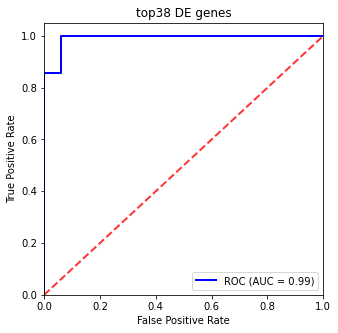

{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}


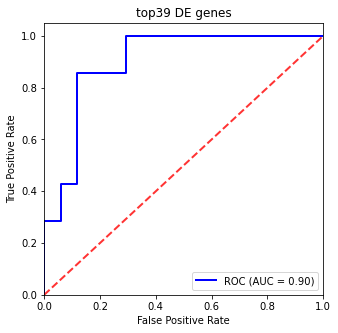

{'C': 0.01, 'gamma': 0.1, 'kernel': 'sigmoid'}


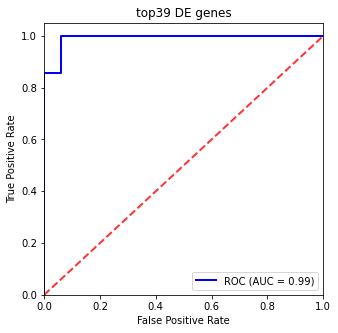

{'C': 1.0, 'gamma': 0.05, 'kernel': 'sigmoid'}


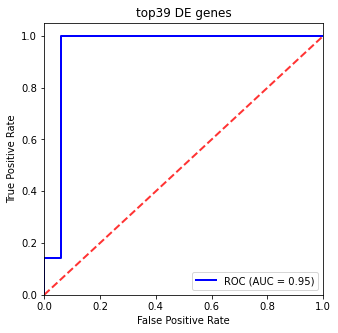

{'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'}


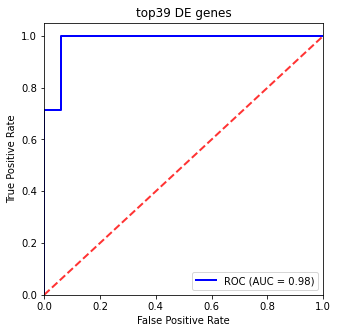

{'C': 0.1, 'gamma': 0.5, 'kernel': 'sigmoid'}


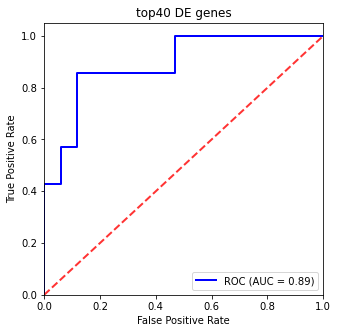

{'C': 1.0, 'gamma': 0.01, 'kernel': 'sigmoid'}


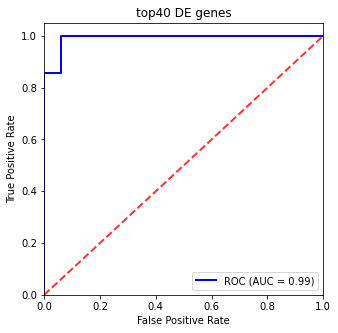

{'C': 1.0, 'gamma': 0.05, 'kernel': 'sigmoid'}


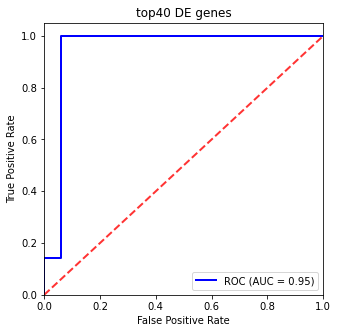

{'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'}


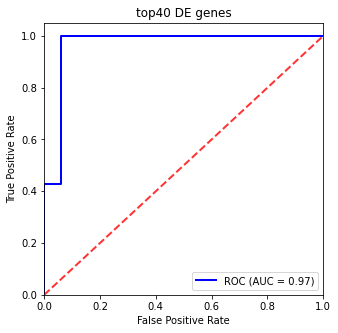

In [552]:
## No need to re-run the following code - takes time
auc_scores_0, auc_scores_5, auc_scores_10, auc_scores_20 = [], [], [], []
for i in range(1, 41):
    auc_scores_0.append(svm_top_feat(df_0, degenes_0.head(i)['Gene_ID'], savefig=False))
    auc_scores_5.append(svm_top_feat(df_5, degenes_5.head(i)['Gene_ID'], savefig=False))
    auc_scores_10.append(svm_top_feat(df_10, degenes_10.head(i)['Gene_ID'], savefig=False))
    auc_scores_20.append(svm_top_feat(df_20, degenes_20.head(i)['Gene_ID'], savefig=False))

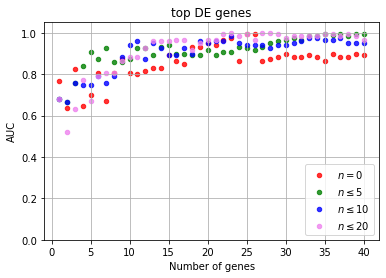

In [553]:
## Plot the AUC-ROC as the nubmer of genes increase
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(np.arange(1,41), auc_scores_0, label=r'$n = 0$', color='r', s=20, alpha=0.8)
ax.scatter(np.arange(1,41), auc_scores_5, label=r'$n \leq 5$', color='green', s=20, alpha=0.8)
ax.scatter(np.arange(1,41), auc_scores_10, label=r'$n \leq 10$', color='blue', s=20, alpha=0.8)
ax.scatter(np.arange(1,41), auc_scores_20, label=r'$n \leq 20$', color='violet', s=20, alpha=0.8)
ax.set_ylim((0.0, 1.05))
ax.set_xlabel('Number of genes')
ax.set_ylabel('AUC')
ax.set_title('top DE genes')
ax.legend(loc='lower right')
plt.grid()
plt.savefig("images/top_DE_genes_auc.png")
plt.show()

In [512]:
def svm_top_feat(dat, feat, outname=None, title=None, pca_=False, savefig=True):
    df_sel = dat.loc[dat.index.isin(feat),]
    X = df_sel.transpose()
    y = np.concatenate((np.ones(28, dtype=int), np.zeros(68, dtype=int)), axis=None)

    X = StandardScaler().fit_transform(X)

    # Run classifier with cross-validation and plot ROC curves
    if pca_:
        pca = PCA(n_components=0.95, whiten=True).fit(X)
        X = pca.transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=24)
    
    search_space = [{'kernel': ['linear', 'rbf', 'sigmoid'],
                     'C': np.logspace(-4, 2, 7),
                     'gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1]}]
    svm = SVC(max_iter=1000, random_state=42, probability=True)
    clf = GridSearchCV(estimator=svm, param_grid=search_space, scoring='roc_auc_ovr', 
               cv=StratifiedKFold(n_splits=5), refit=True, verbose=0)
    clf.fit(X_train, y_train)
    print(clf.cv_results_['params'][np.argmin(clf.cv_results_['rank_test_score'])])

    fig, ax = plt.subplots(figsize=(5,5))
    viz = plot_roc_curve(clf, X_test, y_test, ax=ax, name='ROC', color='blue', lw=2)
    auc_roc = auc(viz.fpr, viz.tpr)
#     print(auc_roc)
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    if not title:
        if not pca_:
            ax.set_title('top{} DE genes'.format(df_sel.shape[0]))
        else:
            ax.set_title('top{} DE genes, {} PCs'.format(df_sel.shape[0], pca.n_components))
    else:
        if not pca_:
            ax.set_title('{}\n{} genes'.format(title, df_sel.shape[0]))
        else:
            ax.set_title('{}\n{} genes, {} PCs'.format(title, df_sel.shape[0], pca.n_components_))
    ax.legend(loc='lower right')
    if savefig:
        if not outname:
            plt.savefig("top{}genes_svm_roc.png".format(len(feat)))
        else:
            plt.savefig(outname+'.png')
    plt.show()
    
    return auc_roc

## SVM with gene panels as features

**SMALL** Panels: H/I, PAM50, Oncotype DX, BreastOncDx, HTICS, eXagenBC, Mammostrat, ProEx, MapQuant

In [395]:
ens[ens['Gene name'].isin(hi)]

,Gene stable ID,Gene type,Transcript type,Gene name,Transcript name
116759,ENSG00000159184,protein_coding,protein_coding,HOXB13,HOXB13-201


{'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf'}


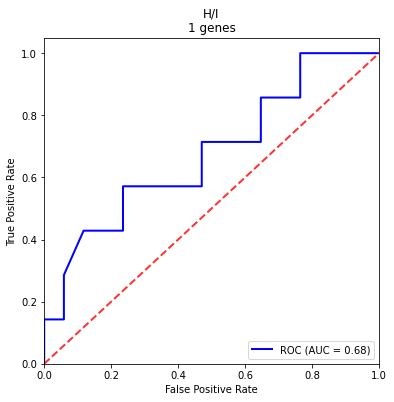

In [396]:
# Gene panels from the paper
# actually only HOXB13 can be mapped in our dataset
hi = ['HOXB13', 'IL17BR']
svm_top_feat(df, ens[ens['Gene name'].isin(hi)]['Gene stable ID'], outname='hi_svm', title='H/I')

In [327]:
pam50 = "UBE2T, BIRC5, NUF2, CDC6, CCNB1, TYMS, MYBL2, CEP55, MELK, NDC80, RRM2, UBE2C, CENPF, PTTG1, EXO1, ORC6L, ANLN, CCNE1, CDC20, MKI67, KIF2C, ACTR3B, MYC, EGFR, KRT5, PHGDH, CDH3, MIA, KRT17, FOXC1, SFRP1, KRT14, ESR1, SLC39A6, BAG1, MAPT, PGR, CXXC5, MLPH, BCL2, MDM2, NAT1, FOXA1, BLVRA, MMP11, GPR160, FGFR4, GRB7, TMEM45B, ERBB2"
pam50 = pam50.split(', ')
print(pam50)
len(pam50)

['UBE2T', 'BIRC5', 'NUF2', 'CDC6', 'CCNB1', 'TYMS', 'MYBL2', 'CEP55', 'MELK', 'NDC80', 'RRM2', 'UBE2C', 'CENPF', 'PTTG1', 'EXO1', 'ORC6L', 'ANLN', 'CCNE1', 'CDC20', 'MKI67', 'KIF2C', 'ACTR3B', 'MYC', 'EGFR', 'KRT5', 'PHGDH', 'CDH3', 'MIA', 'KRT17', 'FOXC1', 'SFRP1', 'KRT14', 'ESR1', 'SLC39A6', 'BAG1', 'MAPT', 'PGR', 'CXXC5', 'MLPH', 'BCL2', 'MDM2', 'NAT1', 'FOXA1', 'BLVRA', 'MMP11', 'GPR160', 'FGFR4', 'GRB7', 'TMEM45B', 'ERBB2']


50

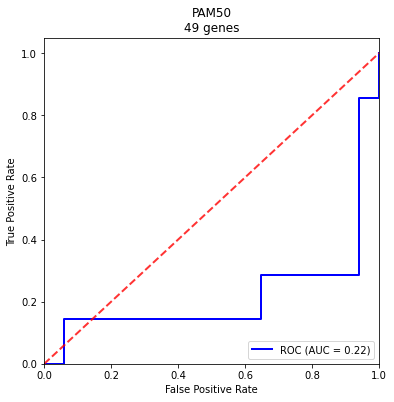

In [367]:
svm_top_feat(df, ens[ens['Gene name'].isin(pam50)]['Gene stable ID'], outname='pam50_svm', title='PAM50')

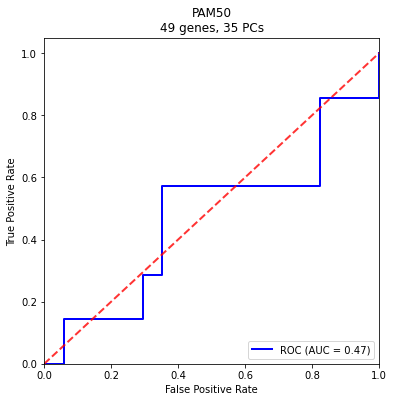

In [368]:
# add PCA
svm_top_feat(df, ens[ens['Gene name'].isin(pam50)]['Gene stable ID'], outname='pam50_pca_svm', title='PAM50', pca_=True)

In [333]:
onco = "BAG1, BCL2, CCNB1, CD68, SCUBE2, CTSL2, ESR1, GRB7, GSTM1, ERBB2, MKI67, MYBL2, PGR, AURKA, MMP11, BIRC5, ACTB, GAPDH, GUSB, RPLP0, TFRC"
onco = onco.split(', ')
print(onco)
len(onco)

['BAG1', 'BCL2', 'CCNB1', 'CD68', 'SCUBE2', 'CTSL2', 'ESR1', 'GRB7', 'GSTM1', 'ERBB2', 'MKI67', 'MYBL2', 'PGR', 'AURKA', 'MMP11', 'BIRC5', 'ACTB', 'GAPDH', 'GUSB', 'RPLP0', 'TFRC']


21

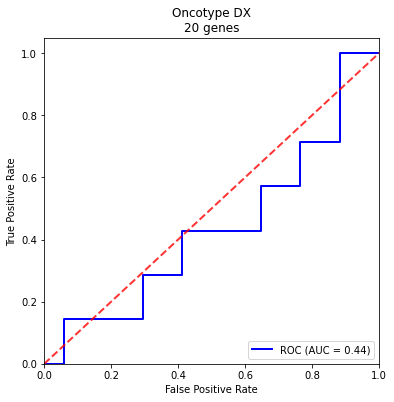

In [369]:
svm_top_feat(df, ens[ens['Gene name'].isin(onco)]['Gene stable ID'], outname='onco_svm', title='Oncotype DX')

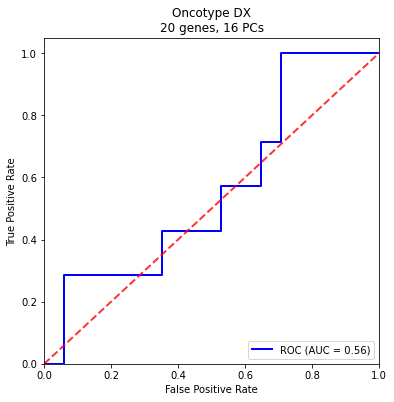

In [370]:
svm_top_feat(df, ens[ens['Gene name'].isin(onco)]['Gene stable ID'], outname='onco_pca_svm', title='Oncotype DX', pca_=True)

In [371]:
bop = "BUB1, CCNB1, CENPA, DC13, DIAPH3, MELK, MYBL2, ORC6L, PKMYT1, PRR11, RACGAP1, RFC4, TK1, UBE2S"
bop = bop.split(', ')
print(bop)
len(bop)

['BUB1', 'CCNB1', 'CENPA', 'DC13', 'DIAPH3', 'MELK', 'MYBL2', 'ORC6L', 'PKMYT1', 'PRR11', 'RACGAP1', 'RFC4', 'TK1', 'UBE2S']


14

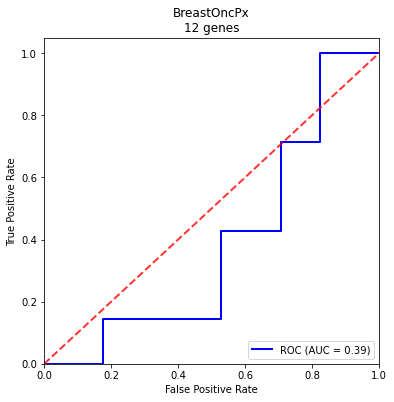

In [372]:
svm_top_feat(df, ens[ens['Gene name'].isin(bop)]['Gene stable ID'], outname='bop_svm', title='BreastOncPx')

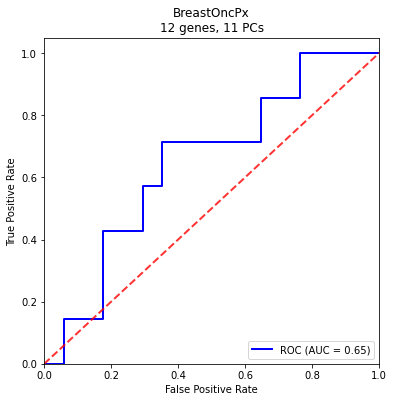

In [373]:
svm_top_feat(df, ens[ens['Gene name'].isin(bop)]['Gene stable ID'], outname='bop_pca_svm', title='BreastOncPx', pca_=True)

In [424]:
mprint = """BBC3, EGLN1, TGFB3, ESM1, IGFBP5, FGF18, SCUBE2, TGFB3, WISP1, FLT1, HRASLS, STK32B, RASSF7, DCK, 
            MELK, EXT1, GNAZ, EBF4, MTDH, PITRM1, QSCN6L1, CCNE2, ECT2, CENPA, LIN9, KNTC2, MCM6, NUSAP1, ORC6L, 
            TSPYL5, RUNDC1, PRC1, RFC4, RECQL5, CDCA7, DTL, COL4A2, GPR180, MMP9, GPR126, RTN4RL1, DIAPH3, CDC42BPA, 
            PALM2, ALDH4A1, LPCAT1, LPCAT2, LPCAT4, OXCT1, PECI, GMPS, GSTM3, SLC2A3, FLT1, FGF18, COL4A2, GPR180, 
            EGLN1, MMP9, C9orf30, ZNF533, C16orf61, SERF1A, C20orf46, LGP2, NMU, UCHL5, JHDM1D, AP2B1, MS4A7, RAB6B"""
mprint = re.split('[\n, ]+', mprint)
print(mprint)
len(mprint)

['BBC3', 'EGLN1', 'TGFB3', 'ESM1', 'IGFBP5', 'FGF18', 'SCUBE2', 'TGFB3', 'WISP1', 'FLT1', 'HRASLS', 'STK32B', 'RASSF7', 'DCK', 'MELK', 'EXT1', 'GNAZ', 'EBF4', 'MTDH', 'PITRM1', 'QSCN6L1', 'CCNE2', 'ECT2', 'CENPA', 'LIN9', 'KNTC2', 'MCM6', 'NUSAP1', 'ORC6L', 'TSPYL5', 'RUNDC1', 'PRC1', 'RFC4', 'RECQL5', 'CDCA7', 'DTL', 'COL4A2', 'GPR180', 'MMP9', 'GPR126', 'RTN4RL1', 'DIAPH3', 'CDC42BPA', 'PALM2', 'ALDH4A1', 'LPCAT1', 'LPCAT2', 'LPCAT4', 'OXCT1', 'PECI', 'GMPS', 'GSTM3', 'SLC2A3', 'FLT1', 'FGF18', 'COL4A2', 'GPR180', 'EGLN1', 'MMP9', 'C9orf30', 'ZNF533', 'C16orf61', 'SERF1A', 'C20orf46', 'LGP2', 'NMU', 'UCHL5', 'JHDM1D', 'AP2B1', 'MS4A7', 'RAB6B']


71

{'C': 0.001, 'gamma': 0.05, 'kernel': 'rbf'}


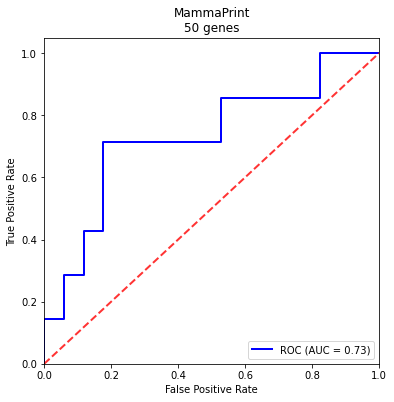

In [398]:
svm_top_feat(df, ens[ens['Gene name'].isin(mprint)]['Gene stable ID'], outname='mprint_svm', title='MammaPrint')

In [423]:
hdpp = """ABCD4, ADD3, AFP, AFTIPHILIN, ALAS2, ANPEP, ARHGAP19, ARIH2,
          ATOH8, ATP8B2, AXIN2, BIN3, BMP4, C11orf57, C12orf29, C14orf49,
          C17orf68, C6orf188, C6orf190, C7orf25, CASP6, CD3D, CD55, CD69,
          CDON, CFL2, CLCN7, CLSTN3, COL8A1, COLEC12, COMP, CRMP1,
          CX3CR1, CXCR4, CYorf15B, DCBLD1, DDEF2, DKFZp686E10196, DMN,
          DPYSL2, DRCTNNB1A, EDG5, EDNRB, ELMO3, EPB41, ETS1, FAIM3,
          FAM46A, FAM89A, FGF2, FLNC, FYN, GAS7, GLRX2, GLTSCR1, GPC3,
          GPR172A, GPX3, GRB7, GRHL1, GYPC, HEMGN, HHIP, HMHA1, HSPBP1,
          IL17RD, INHBA, IRF6, ITGA4, ITM2A, KIAA1549, KIAA1754L, KIAA1826,
          KIRREL, KLF9, KPNA3, LAD1, LAT, LOC116143, LOC133308, LOC90624,
          LONRF1, LPGAT1, LTBP1, LTBP4, MAP4, MAP7D3, MARCH8, MED19,
          MFAP4, MGC40579, MLXIPL, MTHFR, NDN, NLGN2, NUDT9, OSBPL3,
          PDE2A, PELI2, PERLD1, PEX11B, PGM2L1, PIM1, PKP3, PLAC8, PLAU,
          PLXNA4B, PPP1R14A, PPP5C, PRKCA, PRSS12, PTPRCAP, PXDN,
          RAC2, RASIP1, RBM5, RBP4, RFT1, RNF166, S100A11, S100B, SDPR,
          SEMA6A, SEMA7A, SENP5, SFRS5, SH3BP5, SH3KBP1, SH3YL1,
          SLC16A7, SLC25A42, SLC38A5, SLK, SNCA, SNF1LK2, SOCS1, SOX10,
          SPTBN2, ST3GAL2, ST6GALNAC6, STARD4, STAT5A, STON2, STXBP1,
          TCF7, TF, TGFBR3, TIGA1, TLE4, TMEFF1, TSPAN7, UBE2G1, WDHD1,ZAP70, ZNF276, ZNF281, ZNF609, ZNF690"""
hdpp = re.split('[\n, ]+', hdpp)
print(hdpp)
len(hdpp)

['ABCD4', 'ADD3', 'AFP', 'AFTIPHILIN', 'ALAS2', 'ANPEP', 'ARHGAP19', 'ARIH2', 'ATOH8', 'ATP8B2', 'AXIN2', 'BIN3', 'BMP4', 'C11orf57', 'C12orf29', 'C14orf49', 'C17orf68', 'C6orf188', 'C6orf190', 'C7orf25', 'CASP6', 'CD3D', 'CD55', 'CD69', 'CDON', 'CFL2', 'CLCN7', 'CLSTN3', 'COL8A1', 'COLEC12', 'COMP', 'CRMP1', 'CX3CR1', 'CXCR4', 'CYorf15B', 'DCBLD1', 'DDEF2', 'DKFZp686E10196', 'DMN', 'DPYSL2', 'DRCTNNB1A', 'EDG5', 'EDNRB', 'ELMO3', 'EPB41', 'ETS1', 'FAIM3', 'FAM46A', 'FAM89A', 'FGF2', 'FLNC', 'FYN', 'GAS7', 'GLRX2', 'GLTSCR1', 'GPC3', 'GPR172A', 'GPX3', 'GRB7', 'GRHL1', 'GYPC', 'HEMGN', 'HHIP', 'HMHA1', 'HSPBP1', 'IL17RD', 'INHBA', 'IRF6', 'ITGA4', 'ITM2A', 'KIAA1549', 'KIAA1754L', 'KIAA1826', 'KIRREL', 'KLF9', 'KPNA3', 'LAD1', 'LAT', 'LOC116143', 'LOC133308', 'LOC90624', 'LONRF1', 'LPGAT1', 'LTBP1', 'LTBP4', 'MAP4', 'MAP7D3', 'MARCH8', 'MED19', 'MFAP4', 'MGC40579', 'MLXIPL', 'MTHFR', 'NDN', 'NLGN2', 'NUDT9', 'OSBPL3', 'PDE2A', 'PELI2', 'PERLD1', 'PEX11B', 'PGM2L1', 'PIM1', 'PKP3', 'PLA

158

{'C': 100.0, 'gamma': 0.01, 'kernel': 'sigmoid'}


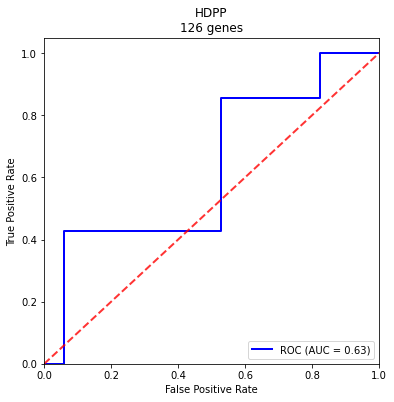

In [426]:
svm_top_feat(df, ens[ens['Gene name'].isin(hdpp)]['Gene stable ID'], outname='hdpp_svm', title='HDPP')

In [335]:
htics = "AURKB, CCNA2, SCRN1, NPY, ATP7B, CHAF1B, CCNB1, CLDN8, NRP1, CCR2, C1QB, CD74, VCAM1, CD180, ITGB2, CD72, ST8SIA4"
htics = htics.split(', ')
print(htics)
len(htics)

['AURKB', 'CCNA2', 'SCRN1', 'NPY', 'ATP7B', 'CHAF1B', 'CCNB1', 'CLDN8', 'NRP1', 'CCR2', 'C1QB', 'CD74', 'VCAM1', 'CD180', 'ITGB2', 'CD72', 'ST8SIA4']


17

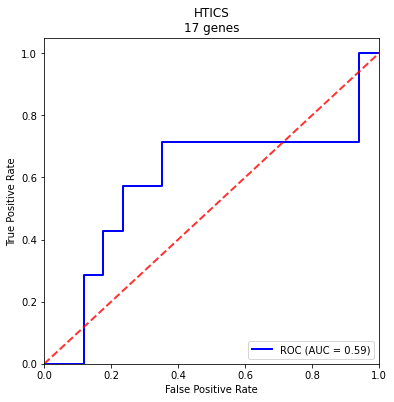

In [374]:
svm_top_feat(df, ens[ens['Gene name'].isin(htics)]['Gene stable ID'], outname='htics_svm', title='HTICS')

In [337]:
exbc = "CYP2D6, CYP24, PDCD6IP, BIRC5, NR1D1, SMARCE1" 
exbc = exbc.split(', ')
print(exbc)
len(exbc)

['CYP2D6', 'CYP24', 'PDCD6IP', 'BIRC5', 'NR1D1', 'SMARCE1']


6

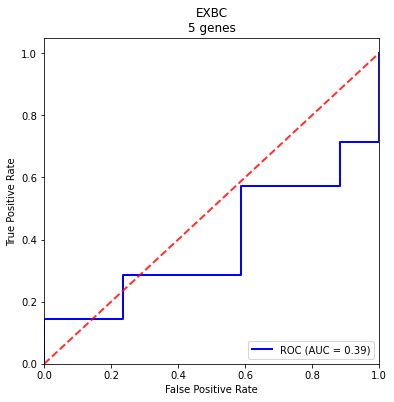

In [376]:
svm_top_feat(df, ens[ens['Gene name'].isin(exbc)]['Gene stable ID'], outname='exbc_svm', title='EXBC')

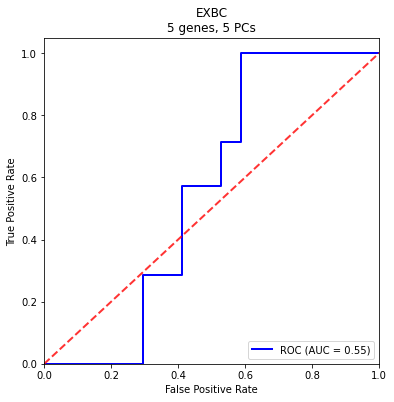

In [377]:
svm_top_feat(df, ens[ens['Gene name'].isin(exbc)]['Gene stable ID'], outname='exbc_pca_svm', title='EXBC', pca_=True)

In [339]:
mstrat = "TP53, NDRG1, CEACAM5, SLC7A2, SLC7A5, TRMT2A"
mstrat = mstrat.split(', ')
print(mstrat)
len(mstrat)

['TP53', 'NDRG1', 'CEACAM5', 'SLC7A2', 'SLC7A5', 'TRMT2A']


6

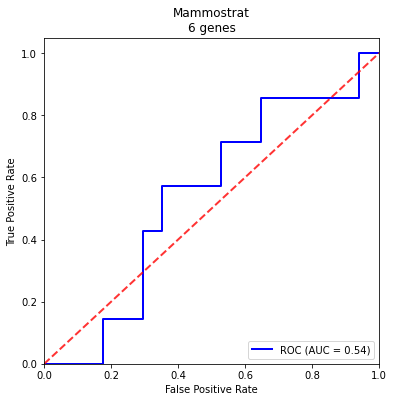

In [378]:
svm_top_feat(df, ens[ens['Gene name'].isin(mstrat)]['Gene stable ID'], outname='mstrat_svm', title='Mammostrat')

In [320]:
peb = "E2F1, RASA1, PSMB1".split(', ')
print(peb)

['E2F1', 'RASA1', 'PSMB1']


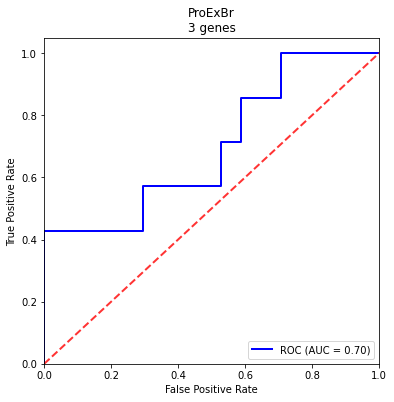

In [380]:
svm_top_feat(df, ens[ens['Gene name'].isin(peb)]['Gene stable ID'], outname='peb_svm', title='ProExBr')

In [432]:
rott = """CLN8, GOLM1, YIF1A, IL18, CBX3, DUSP4, PPP1CC, ABLIM1, TNFSF13,
          TMEM8A, C3, NCAPG2, C11orf9, MAP4, TACC2, SMC4, OR12D2, ORC3,
          ATAD2, SMC4, DUSP4, CD44, PLK1, CNKSR1, Hs.591790, FEN1, FKBP2,
          KPNA2, RRNAD1, GFOD2, AP2A2, MLF1IP, NEURL, SUPT16H, ZFP36L2,
          ARHGDIB, PSMC2, ZCCHC8, ANKHD1-EIF4EBP3, CD44, SLC35A1,
          CCNE2, PHF11, POLQ, CAPN2, ETV2, UCKL1, LST1, ACACB, Hs.505202,
          EEF1A2, NEFL, TNFSF13, MMP23B, GTSE1, RFX7, COL2A1, GAS2,
          ZNF362, FUT3, MYH2, TNFSF10, RPL23AP7, GABRQ, PARP4, C11orf51,
          BCL2L14, CEP57, RPS4XP3, ACOT11"""
rott = re.split('[\n, ]+', rott)
print(rott)
len(rott)

['CLN8', 'GOLM1', 'YIF1A', 'IL18', 'CBX3', 'DUSP4', 'PPP1CC', 'ABLIM1', 'TNFSF13', 'TMEM8A', 'C3', 'NCAPG2', 'C11orf9', 'MAP4', 'TACC2', 'SMC4', 'OR12D2', 'ORC3', 'ATAD2', 'SMC4', 'DUSP4', 'CD44', 'PLK1', 'CNKSR1', 'Hs.591790', 'FEN1', 'FKBP2', 'KPNA2', 'RRNAD1', 'GFOD2', 'AP2A2', 'MLF1IP', 'NEURL', 'SUPT16H', 'ZFP36L2', 'ARHGDIB', 'PSMC2', 'ZCCHC8', 'ANKHD1-EIF4EBP3', 'CD44', 'SLC35A1', 'CCNE2', 'PHF11', 'POLQ', 'CAPN2', 'ETV2', 'UCKL1', 'LST1', 'ACACB', 'Hs.505202', 'EEF1A2', 'NEFL', 'TNFSF13', 'MMP23B', 'GTSE1', 'RFX7', 'COL2A1', 'GAS2', 'ZNF362', 'FUT3', 'MYH2', 'TNFSF10', 'RPL23AP7', 'GABRQ', 'PARP4', 'C11orf51', 'BCL2L14', 'CEP57', 'RPS4XP3', 'ACOT11']


70

{'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}


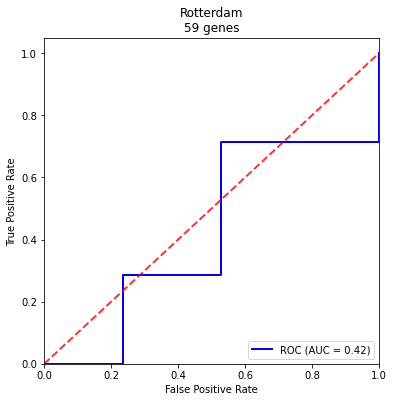

In [433]:
svm_top_feat(df, ens[ens['Gene name'].isin(rott)]['Gene stable ID'], outname='rott_svm', title='Rotterdam')

{'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}


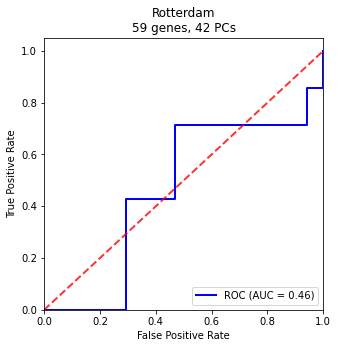

In [505]:
svm_top_feat(df, ens[ens['Gene name'].isin(rott)]['Gene stable ID'], outname='rott_pca_svm', title='Rotterdam', pca_=True)

In [343]:
mqd = "UBE2C, KPNA2, TPX2, FOXM1, STK6, CCNA2, BIRC5, MYBL2".split(', ')
print(mqd)
len(mqd)

['UBE2C', 'KPNA2', 'TPX2', 'FOXM1', 'STK6', 'CCNA2', 'BIRC5', 'MYBL2']


8

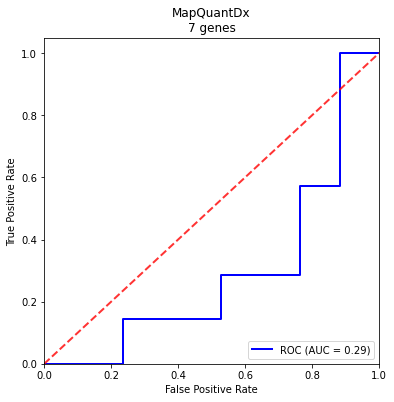

In [381]:
svm_top_feat(df, ens[ens['Gene name'].isin(mqd)]['Gene stable ID'], outname='mqd_svm', title='MapQuantDx')

{'C': 0.0001, 'gamma': 0.05, 'kernel': 'sigmoid'}


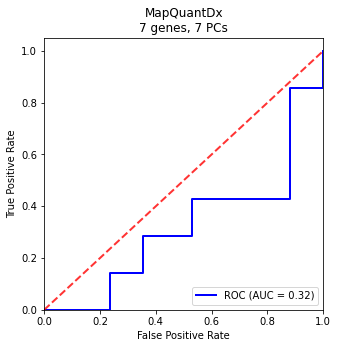

In [506]:
svm_top_feat(df, ens[ens['Gene name'].isin(mqd)]['Gene stable ID'], outname='mqd_pca_svm', title='MapQuantDx', pca_=True)

In [435]:
igs = """DPF2, CASP8, BCL2, SCGN, SWAP70, KIAA0276, C10orf9, C10orf7, TOB2,
        XPR1, CD59, LRP2, PLP2, MAPK14, CXCL2, MMP7, MGP, MLF1, FLNB,
        SCNM1, HSPC163, C5orf18, MGC4399, CDW92, TMC4, ZDHHC2, TICAM2,
        KDELR3, GNPDA1, THEM2, DBR1, FLJ90709, FLJ10774, C16orf33, GAPD,
        LDHA, MR1, LARS, GTPBP1, PRSS16, WFDC2, AIM1, DHRS6, DHRS4,
        MGC15429, MGC45840, ECHDC2, GOLGA8B, GOLGA8A, KIAA0436,
        CYP4V2, JTV1, ICMT, DNMT3A, HNMT, METTL7A, METTL2, VIL2, TPD52,
        ARPC5, NOL8, NSF, RAD23B, SRP54, HSPA2, THAP2, CIRBP, SNRPN,
        KIAA0052, DUSP10, SSR1, ERBB4, EMP1, CHPT1, LRPAP1, FLJ11752,
        CSTF1, KLHL20, DNAJC13, APLP2, ARGBP2, DNAJB1, NEBL, SH3BGRL,
        NUDT5, GABARAPL1, MAPT, DCBLD1, STK39, PAK2, CSNK2A1, PILRB,
        ERN1, SGK3, WEE1, MAST4, C11orf17, NUP37, CLTC, COPB2,
        SLC25A25, ECOP, PDE8A, STAM, TUBB, SNX6, RAB23, PLAA, STC2, LTF,
        ISGF3G, ATXN3, GTF3C3, GSK3B, KLF10, ELL2, ZBTB20, IRX3, ETS1,
        SERTAD1, MGC4251, MAFF, SFPQ, CITED4, CEBPD, EIF4E2, HS2ST1,
        AGPS, PGK1, ATIC, ETNK1, ALG2, NCE2, 8-Mar, CNOT4, RNF8, PSMA5,
        DPF2, AMMECR1, KIAA1287, LOC144233, NPAS-4, FLJ20530, THUMPD3,
        MGC45564, CAP350, ETAA16, HAN11, DNAPTP6, C7orf25, FLJ37953,
        FLJ10587, C7orf36, ELP4, NDEL1, NPD014, DKFZP564D172, FAM53C,
        IER5, LOC255783, KIAA0146, KIAA0792, LOC283481, CG018, LOC130576,
        NGFRAP1L1, KIAA1217, C4orf7, C21orf86, C9orf64, FLJ13456, KIAA1600,
        B7-H4, C7orf2, NUCKS, DKFZP566D1346, LOC388279, FLJ31795,
        C6orf107, FLJ12439, FLJ12806, FLJ39370"""
igs = re.split('[\n, ]+', igs)
print(igs)
len(igs)

['DPF2', 'CASP8', 'BCL2', 'SCGN', 'SWAP70', 'KIAA0276', 'C10orf9', 'C10orf7', 'TOB2', 'XPR1', 'CD59', 'LRP2', 'PLP2', 'MAPK14', 'CXCL2', 'MMP7', 'MGP', 'MLF1', 'FLNB', 'SCNM1', 'HSPC163', 'C5orf18', 'MGC4399', 'CDW92', 'TMC4', 'ZDHHC2', 'TICAM2', 'KDELR3', 'GNPDA1', 'THEM2', 'DBR1', 'FLJ90709', 'FLJ10774', 'C16orf33', 'GAPD', 'LDHA', 'MR1', 'LARS', 'GTPBP1', 'PRSS16', 'WFDC2', 'AIM1', 'DHRS6', 'DHRS4', 'MGC15429', 'MGC45840', 'ECHDC2', 'GOLGA8B', 'GOLGA8A', 'KIAA0436', 'CYP4V2', 'JTV1', 'ICMT', 'DNMT3A', 'HNMT', 'METTL7A', 'METTL2', 'VIL2', 'TPD52', 'ARPC5', 'NOL8', 'NSF', 'RAD23B', 'SRP54', 'HSPA2', 'THAP2', 'CIRBP', 'SNRPN', 'KIAA0052', 'DUSP10', 'SSR1', 'ERBB4', 'EMP1', 'CHPT1', 'LRPAP1', 'FLJ11752', 'CSTF1', 'KLHL20', 'DNAJC13', 'APLP2', 'ARGBP2', 'DNAJB1', 'NEBL', 'SH3BGRL', 'NUDT5', 'GABARAPL1', 'MAPT', 'DCBLD1', 'STK39', 'PAK2', 'CSNK2A1', 'PILRB', 'ERN1', 'SGK3', 'WEE1', 'MAST4', 'C11orf17', 'NUP37', 'CLTC', 'COPB2', 'SLC25A25', 'ECOP', 'PDE8A', 'STAM', 'TUBB', 'SNX6', 'RAB23',

182

{'C': 0.0001, 'gamma': 0.1, 'kernel': 'rbf'}


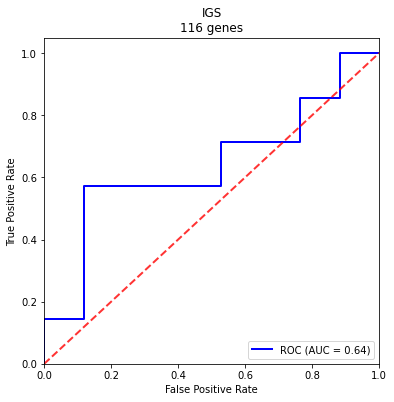

In [436]:
svm_top_feat(df, ens[ens['Gene name'].isin(igs)]['Gene stable ID'], outname='igs_svm', title='IGS')

In [425]:
nuvo = """DD96, FCGR3A, PLD3, CCNL2, PP591, SEC61A1, KPNA2, NFAT5, HN1, DKFZP564I1171, SLC35B1, PCDHB2, 
          NME1, EFEMP1, SLC35B1, RALGDS, SURF4, KRT13, FLJ13855, GSR, ATF5, LCHN, PTPRC, ACLY,FAAH, RTKN, 
          FLJ20323, STOML1, MGST1, CREM, PB1, ANXA8, FLJ11196, HSPC134, HBOA, TFRC, TCEB3, APH1A, KIAA1041, 
          PRPSAP1, EPB42, KIAA0742, NME2, TBPL1, GTF2H3, SLC7A10, NDP, SCARA3, APOE, DKFZP434F195, KIAA1155"""
nuvo = re.split('[\n, ]+', nuvo)
print(nuvo)
len(nuvo)

['DD96', 'FCGR3A', 'PLD3', 'CCNL2', 'PP591', 'SEC61A1', 'KPNA2', 'NFAT5', 'HN1', 'DKFZP564I1171', 'SLC35B1', 'PCDHB2', 'NME1', 'EFEMP1', 'SLC35B1', 'RALGDS', 'SURF4', 'KRT13', 'FLJ13855', 'GSR', 'ATF5', 'LCHN', 'PTPRC', 'ACLY', 'FAAH', 'RTKN', 'FLJ20323', 'STOML1', 'MGST1', 'CREM', 'PB1', 'ANXA8', 'FLJ11196', 'HSPC134', 'HBOA', 'TFRC', 'TCEB3', 'APH1A', 'KIAA1041', 'PRPSAP1', 'EPB42', 'KIAA0742', 'NME2', 'TBPL1', 'GTF2H3', 'SLC7A10', 'NDP', 'SCARA3', 'APOE', 'DKFZP434F195', 'KIAA1155']


51

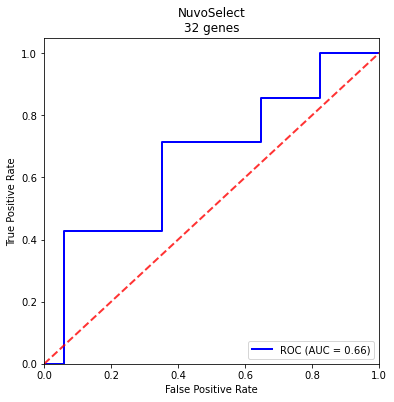

In [383]:
svm_top_feat(df, ens[ens['Gene name'].isin(nuvo)]['Gene stable ID'], outname='nuvo_svm', title='NuvoSelect')

In [438]:
pexpr = """TOP2A, EGFR, FOXA1, PIP, BigH3
            MCM2, HERV-K, KI67, CAP2, SNCG, DAP, CENP-A, MDC1, PRKCA, YB-1, 5-LOX, GRB7, HER2,
            MKI67, CCNA1, CCNA2, CCNB1, CCNB2, CCNB3, CCNC, CCND1, CCND2,
            CCND3, CCNE1, CCNE2, CCNF, CCNG1, CCNG2, CCNH, CCNI, CCNI2,
            CCNJ, CCNJL, CCNK, CCNL1, CCNL2, CCNO, CCNT1, CCNT2, CCNY,
            CCNYL1, CCNYL2, CCNYL3, PLAU, TP53, CDKN1A, CASP9, BAK1, BAD,
            BCL2L11, BCL2A1, BCL2L1, CASP4, AIFM1, TIAF1, BCL2, CASP3, SIVA1,
            BAX, PAWR, BRCA1, BRCA2, ESR1, ESR2, PGR, AR, NME1"""
pexpr = re.split('[\n, ]+', pexpr)
print(pexpr)
len(pexpr)

['TOP2A', 'EGFR', 'FOXA1', 'PIP', 'BigH3', 'MCM2', 'HERV-K', 'KI67', 'CAP2', 'SNCG', 'DAP', 'CENP-A', 'MDC1', 'PRKCA', 'YB-1', '5-LOX', 'GRB7', 'HER2', 'MKI67', 'CCNA1', 'CCNA2', 'CCNB1', 'CCNB2', 'CCNB3', 'CCNC', 'CCND1', 'CCND2', 'CCND3', 'CCNE1', 'CCNE2', 'CCNF', 'CCNG1', 'CCNG2', 'CCNH', 'CCNI', 'CCNI2', 'CCNJ', 'CCNJL', 'CCNK', 'CCNL1', 'CCNL2', 'CCNO', 'CCNT1', 'CCNT2', 'CCNY', 'CCNYL1', 'CCNYL2', 'CCNYL3', 'PLAU', 'TP53', 'CDKN1A', 'CASP9', 'BAK1', 'BAD', 'BCL2L11', 'BCL2A1', 'BCL2L1', 'CASP4', 'AIFM1', 'TIAF1', 'BCL2', 'CASP3', 'SIVA1', 'BAX', 'PAWR', 'BRCA1', 'BRCA2', 'ESR1', 'ESR2', 'PGR', 'AR', 'NME1']


72

{'C': 0.001, 'gamma': 1, 'kernel': 'sigmoid'}


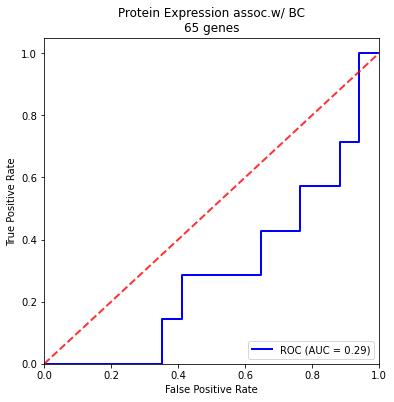

In [439]:
svm_top_feat(df, ens[ens['Gene name'].isin(pexpr)]['Gene stable ID'], outname='pexpr_svm', title='Protein Expression assoc.w/ BC')

In [441]:
rexpr = """PTPN13, PTPL1, EPS15, WDR5, PVRL4, DLC1, CDK6, INPP4B, CCNE1, LINC00472, EPB41L-AS2,
           MEG3, CCAT1, BCYRN1, FGF14-AS2, H19, CCAT2, GAS5, BCAR4, MALAT1, BTG3, ABCB10, LINC-ROR, 
           TWIST2, TWISTNB"""
rexpr = re.split('[\n, ]+', rexpr)
print(rexpr)
len(rexpr)

['PTPN13', 'PTPL1', 'EPS15', 'WDR5', 'PVRL4', 'DLC1', 'CDK6', 'INPP4B', 'CCNE1', 'LINC00472', 'EPB41L-AS2', 'MEG3', 'CCAT1', 'BCYRN1', 'FGF14-AS2', 'H19', 'CCAT2', 'GAS5', 'BCAR4', 'MALAT1', 'BTG3', 'ABCB10', 'LINC-ROR', 'TWIST2', 'TWISTNB']


25

{'C': 0.0001, 'gamma': 0.1, 'kernel': 'rbf'}


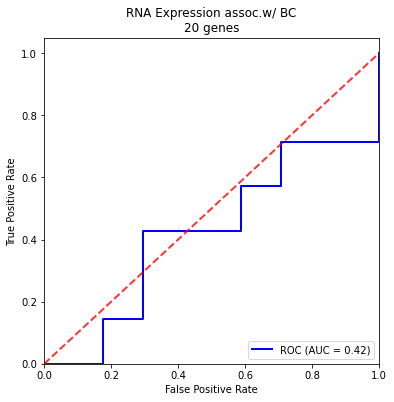

In [442]:
svm_top_feat(df, ens[ens['Gene name'].isin(rexpr)]['Gene stable ID'], outname='rexpr_svm', title='RNA Expression assoc.w/ BC')

{'C': 0.001, 'gamma': 0.05, 'kernel': 'rbf'}


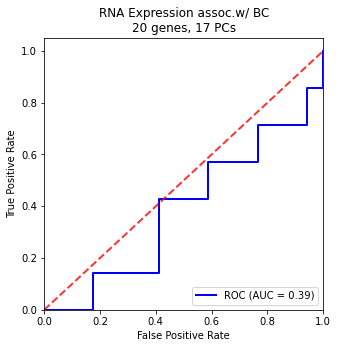

In [507]:
svm_top_feat(df, ens[ens['Gene name'].isin(rexpr)]['Gene stable ID'], outname='rexpr_pca_svm', title='RNA Expression assoc.w/ BC', pca_=True)

In [444]:
dnaseq = """AATK, USP32, ACTB, C20orf112, APOL1, CD74, MBD6, GNB2, CTSD,
KRT18, PLEC, TSPAN14, YWHAZ, HLA-E, ZBTB33, COL1A1, FMNL3,
CYB5R3, TXNIP, DCLK1, COL3A1, ELF3, SLC39A6, MGP, NCRNA00188,
STC2, RNF11, TAX1BP1, MALAT1, 
ACHE, EPHB4, BCHE, MME, TOP2A, ADPRHL1, DCUN1D2, TMCO3, TFDP1, TP53, 
BRCA1, APC, RASSF1A, WIF1, MGMT, MAL, CDH13, RARβ, CDKN2A,
TP73, GSTP1, CDH1, CCND2, RARB, TWIST1, CYP1B1, ARHI, 
PIK3CA, BRCA2, PTEN, RAD50, CHEK2, PALB2, RAD51C, NBN, ATM, FANCM, 
FGFR2, TOX3, MAP3K1, LSP1, HCN1, BRIP1, SULT1A1, RB1, VEGF, MDM2, HLA-G, IL1A,
PDCD6IP, RAD51, APOBEC3A, APOBEC3AP1, APOBEC3B, APOBEC3B-AS1, APOBEC3C,
APOBEC3D, APOBEC3F, APOBEC3G, APOBEC3H, KRAS, NRAS"""
dnaseq = re.split('[\n, ]+', dnaseq)
print(dnaseq)
len(dnaseq)

['AATK', 'USP32', 'ACTB', 'C20orf112', 'APOL1', 'CD74', 'MBD6', 'GNB2', 'CTSD', 'KRT18', 'PLEC', 'TSPAN14', 'YWHAZ', 'HLA-E', 'ZBTB33', 'COL1A1', 'FMNL3', 'CYB5R3', 'TXNIP', 'DCLK1', 'COL3A1', 'ELF3', 'SLC39A6', 'MGP', 'NCRNA00188', 'STC2', 'RNF11', 'TAX1BP1', 'MALAT1', 'ACHE', 'EPHB4', 'BCHE', 'MME', 'TOP2A', 'ADPRHL1', 'DCUN1D2', 'TMCO3', 'TFDP1', 'TP53', 'BRCA1', 'APC', 'RASSF1A', 'WIF1', 'MGMT', 'MAL', 'CDH13', 'RARβ', 'CDKN2A', 'TP73', 'GSTP1', 'CDH1', 'CCND2', 'RARB', 'TWIST1', 'CYP1B1', 'ARHI', 'PIK3CA', 'BRCA2', 'PTEN', 'RAD50', 'CHEK2', 'PALB2', 'RAD51C', 'NBN', 'ATM', 'FANCM', 'FGFR2', 'TOX3', 'MAP3K1', 'LSP1', 'HCN1', 'BRIP1', 'SULT1A1', 'RB1', 'VEGF', 'MDM2', 'HLA-G', 'IL1A', 'PDCD6IP', 'RAD51', 'APOBEC3A', 'APOBEC3AP1', 'APOBEC3B', 'APOBEC3B-AS1', 'APOBEC3C', 'APOBEC3D', 'APOBEC3F', 'APOBEC3G', 'APOBEC3H', 'KRAS', 'NRAS']


91

{'C': 10.0, 'gamma': 0.5, 'kernel': 'sigmoid'}


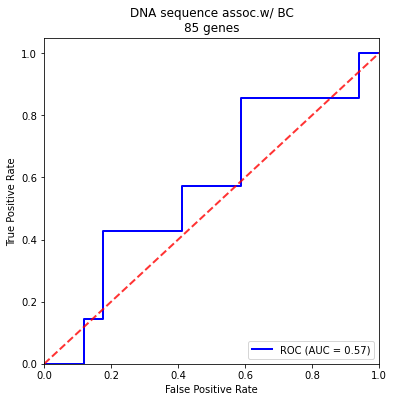

In [445]:
svm_top_feat(df, ens[ens['Gene name'].isin(dnaseq)]['Gene stable ID'], outname='dnaseq_svm', title='DNA sequence assoc.w/ BC')

## Feature selection using Random Forests

In [291]:
def rf_svm(dat, ens, biot, n_trees=100):
    df_sel = dat.loc[dat.index.isin(ens[ens['Gene type'] == biot]['Gene stable ID']),]
    X = df_sel.iloc[:,:].T
    y = np.concatenate((np.ones(28, dtype=int), np.zeros(68, dtype=int)), axis=None)

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=32)
    
    if df_sel.shape[0] < n_trees:
        n_trees = df_sel.shape[0]
    sel = SelectFromModel(RandomForestClassifier(n_estimators = n_trees, random_state=42))
    sel.fit(X_train, y_train)
    selected_feat = X_train.columns[(sel.get_support())]
    
    df_sel2 = dat.loc[selected_feat,]
    X = df_sel2.iloc[:,:].T.to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=32)
    
    search_space = [{'kernel': ['linear', 'rbf', 'sigmoid'],
                     'C': np.logspace(-4, 2, 7),
                     'gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1]}]
    svm = SVC(max_iter=1000, random_state=42, probability=True)
    clf = GridSearchCV(estimator=svm, param_grid=search_space, scoring='roc_auc_ovr', 
                   cv=StratifiedKFold(n_splits=5), refit=True, verbose=0)
    clf.fit(X_train, y_train)

    fig, ax = plt.subplots()

#     ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8, label='chance')
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plot_roc_curve(clf, X_test, y_test, lw=2, color='blue', name='ROC', ax=ax)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('{}\n{} genes, {} features'.format(biot.replace('_',' '), df_sel.shape[0], df_sel2.shape[0]))
    ax.legend(loc='lower right')
    plt.savefig("{}_rf_svm_roc.png".format(biot))
    plt.show()

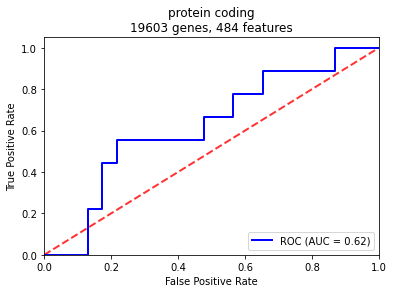

In [295]:
rf_svm(df, ens, 'protein_coding')

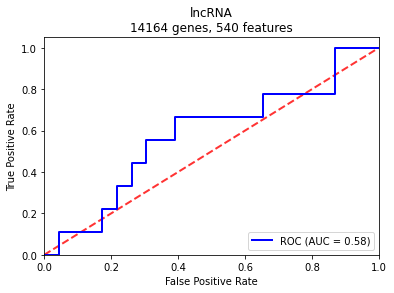

In [294]:
rf_svm(df, ens, 'lncRNA')